In [2]:
import os, sys, time, re, json, glob
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm import tqdm
import scipy.stats as ss
from functools import reduce
import statsmodels.api as sm
import matplotlib.patheffects as pe

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('ggplot')
style.use('seaborn-white')

In [3]:
celltype_map_1k = {'CD4T': ['cd4et', 'cd4nc', 'cd4sox4'],
                   'CD8T': ['cd8et', 'cd8nc', 'cd8s100b'],
                   'monocyte': ['monoc', 'mononc'],
                   'B': ['bin', 'bmem', 'plasma'],
                   'NK': ['nk', 'nkr'],
                   'DC': ['dc']}
celltype_map_1k_inv = {}
for k, v in celltype_map_1k.items():
    for x in v:
        celltype_map_1k_inv[x] = k
celltype_map_1k_inv

{'cd4et': 'CD4T',
 'cd4nc': 'CD4T',
 'cd4sox4': 'CD4T',
 'cd8et': 'CD8T',
 'cd8nc': 'CD8T',
 'cd8s100b': 'CD8T',
 'monoc': 'monocyte',
 'mononc': 'monocyte',
 'bin': 'B',
 'bmem': 'B',
 'plasma': 'B',
 'nk': 'NK',
 'nkr': 'NK',
 'dc': 'DC'}

In [4]:
cell_ids_map = {0: 'CD4T', 1: 'CD8T', 2: 'monocyte', 3: 'B', 4: 'NK', 5: 'DC', 6: 'gtex'}
cell_ids_map_inv = {v: k for k, v in cell_ids_map.items()}
cell_ids_map_inv

{'CD4T': 0, 'CD8T': 1, 'monocyte': 2, 'B': 3, 'NK': 4, 'DC': 5, 'gtex': 6}

In [5]:
sorted_cell_ids_map = {0: 'B', 1: 'CD4T', 2: 'CD8T', 3: 'NK', 4: 'monocyte', 5: 'DC', 6: 'gtex'}
sorted_cell_ids_map_inv = {v: k for k, v in sorted_cell_ids_map.items()}
sorted_cell_ids_map_inv

{'B': 0, 'CD4T': 1, 'CD8T': 2, 'NK': 3, 'monocyte': 4, 'DC': 5, 'gtex': 6}

In [13]:
sorted_cell_names = {'B': 'B', 'CD4T': 'CD4', 'CD8T': 'CD8', 'NK': 'NK', 'monocyte': 'Monocyte', 'DC': 'DC'}
sorted_cell_types = ['B', 'CD4T', 'CD8T', 'NK', 'monocyte', 'DC']

# Results
Script for running IBSEP: scripts/run_blood.sh

## Combine results

In [ ]:
## combine genes by chrom
t0 = time.time()
for chrom in range(1, 23):
    files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/*_CD4T_IBSEP_truncorr_pval1e-10.csv')
    gene_ids = [x.split('/')[-1].split('_')[0] for x in files if x.split('/')[-1].split('_')[0].startswith('ENSG')]
    print(f'{len(gene_ids)} genes in CHR {chrom}.')
    for cell_type in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
        dfs = []
        for i, gene_id in enumerate(gene_ids):
            df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
            df = df[['SNP', 'GENEID', 'BETA_BLUE', 'SE_BLUE', 'PVAL_BLUE']]
            df.columns = ['SNP_1M', 'GENEID_1M', 'BETA_BLUE', 'SE_BLUE', 'PVAL_BLUE']
            dfs.append(df)
        dfs = pd.concat(dfs)
        dfs.to_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/allgenes_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t', index=False)
        print(f'CHR {chrom}: dfs {dfs.shape}.')
t1 = time.time()
print(f'Time: {t1 - t0:.1f}s')

In [ ]:
# combine chroms
res_dfs = {}
for cell_type in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    dfs = []
    for chrom in tqdm(range(1, 23)):
        df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/allgenes_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
        dfs.append(df)
    dfs = pd.concat(dfs)
    dfs.to_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/allchroms_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t', index=False)
    print(f'{cell_type}: {dfs.shape}')
    res_dfs[cell_type] = dfs

In [ ]:
res_dfs = {}
for cell_type in tqdm(['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']):
    df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/allchroms_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
    res_dfs[cell_type] = df

In [ ]:
## remove rows with nan
res_dfs_nonnan = {}
for cell_type in tqdm(['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']):
    dfs = res_dfs[cell_type]
    x = dfs.isnull().any(axis=1)
    dfs_nonnan = dfs.loc[x==False]
    print(cell_type, dfs_nonnan.shape, dfs.shape)
    res_dfs_nonnan[cell_type] = dfs_nonnan

## Zscore scatter plots

In [138]:
cell_type = 'B'
cell_ids = sorted_cell_ids_map_inv[cell_type]
sub_celltypes = celltype_map_1k[cell_type]
t0 = time.time()
df_blue = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/allchroms_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
df_1m = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/allchroms_{cell_type}.csv', sep='\t')
print(cell_type, df_1m.shape, df_blue.shape)
dfs_1k1k = []
for sub_celltype in sub_celltypes:
    df_1k1k_ = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
    dfs_1k1k.append(df_1k1k_[['SNP_1M', 'GENEID_1M', 'BETA_1K1K', 'SE_1K1K', 'PVAL_1K1K']])
    print(sub_celltype, df_1k1k_.shape)
df_1k1k = pd.concat(dfs_1k1k)
print(f'Concated df_1k1k: {df_1k1k.shape}')
idx = df_1k1k.groupby(['SNP_1M', 'GENEID_1M'])['PVAL_1K1K'].transform(min) == df_1k1k['PVAL_1K1K']
df_1k1k = df_1k1k[idx]
print(f'df_1k1k (min pval): {df_1k1k.shape}')
merged_1m_blue = pd.merge(df_1m, df_blue, left_on=['SNP', 'GENEID'], right_on=['SNP_1M', 'GENEID_1M'], how='inner')
merged_1m_blue_1k1k = pd.merge(merged_1m_blue, df_1k1k, on=['SNP_1M', 'GENEID_1M'], how='inner')
print(merged_1m_blue.shape, merged_1m_blue_1k1k.shape)
merged_1m_blue_1k1k['Z'] = merged_1m_blue_1k1k['BETA'] / merged_1m_blue_1k1k['SE']
merged_1m_blue_1k1k['Z_BLUE'] = merged_1m_blue_1k1k['BETA_BLUE'] / merged_1m_blue_1k1k['SE_BLUE']
merged_1m_blue_1k1k['Z_1K1K'] = merged_1m_blue_1k1k['BETA_1K1K'] / merged_1m_blue_1k1k['SE_1K1K']
t1 = time.time()
print(f'{t1 - t0:.1f}s')

DC (1275698, 10) (1275565, 5)
dc (2229461, 20)
Concated df_1k1k: (2229461, 5)
df_1k1k (min pval): (2218088, 5)
(1275565, 15) (1275571, 18)
19.9s


In [139]:
### 1m vs 1k1k
## sig
pval_thres = 1e-5
sig_merged_1m_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL < pval_thres)]
sig_merged_only_1m = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL >= pval_thres)]
print(sig_merged_1m_1k1k.shape, sig_merged_only_1m.shape)
# both sig
z_1m = sig_merged_1m_1k1k.Z.values
z_1k1k = sig_merged_1m_1k1k.Z_1K1K.values
print(len(z_1m), len(z_1k1k))
concord_ids = np.where((z_1m * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_1m * z_1k1k) < 0)[0]
z_1m_con = z_1m[concord_ids]
z_1m_dis = z_1m[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_1m2 = sig_merged_only_1m.Z.values
z_1k1k2 = sig_merged_only_1m.Z_1K1K.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_1m * z_1k1k) >= 0)/len((z_1m * z_1k1k) >= 0)
concord_all = (sum((z_1m * z_1k1k) >= 0) + sum((z_1m2 * z_1k1k2) >= 0)) / (len((z_1m * z_1k1k) >= 0) + len((z_1m2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_1m_1k1k) / (len(sig_merged_1m_1k1k) + len(sig_merged_only_1m))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(1701, 21) (6210, 21)
1701 1701
Concordance sig: 98.8%, concordance all: 97.7%
#Shared eSNPs/#OneK1K eSNPs: 21.5%


In [299]:
mark_row = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.GENENAME=='CD37') & (merged_1m_blue_1k1k.SNP=='rs8108669')]
mark_z = mark_row.Z.values[0]
mark_z_blue = mark_row.Z_BLUE.values[0]
mark_z_1k1k = mark_row.Z_1K1K.values[0]
mark_z, mark_z_blue, mark_z_1k1k

(0.8772221999999996, 5.904701466096849, 12.118746358707293)

In [309]:
mark_row

,CHR,BP,A1,A2,SNP,GENEID,GENENAME,BETA,SE,PVAL,SNP_1M,GENEID_1M,BETA_BLUE,SE_BLUE,PVAL_BLUE,BETA_1K1K,SE_1K1K,PVAL_1K1K,Z,Z_BLUE,Z_1K1K
1105251,19,49845895,T,C,rs8108669,ENSG00000104894,CD37,0.086019,0.098058,0.380269,rs8108669,ENSG00000104894,0.399708,0.067693,3.532859e-09,0.373146,0.030791,8.403471e-34,0.877222,5.904701,12.118746


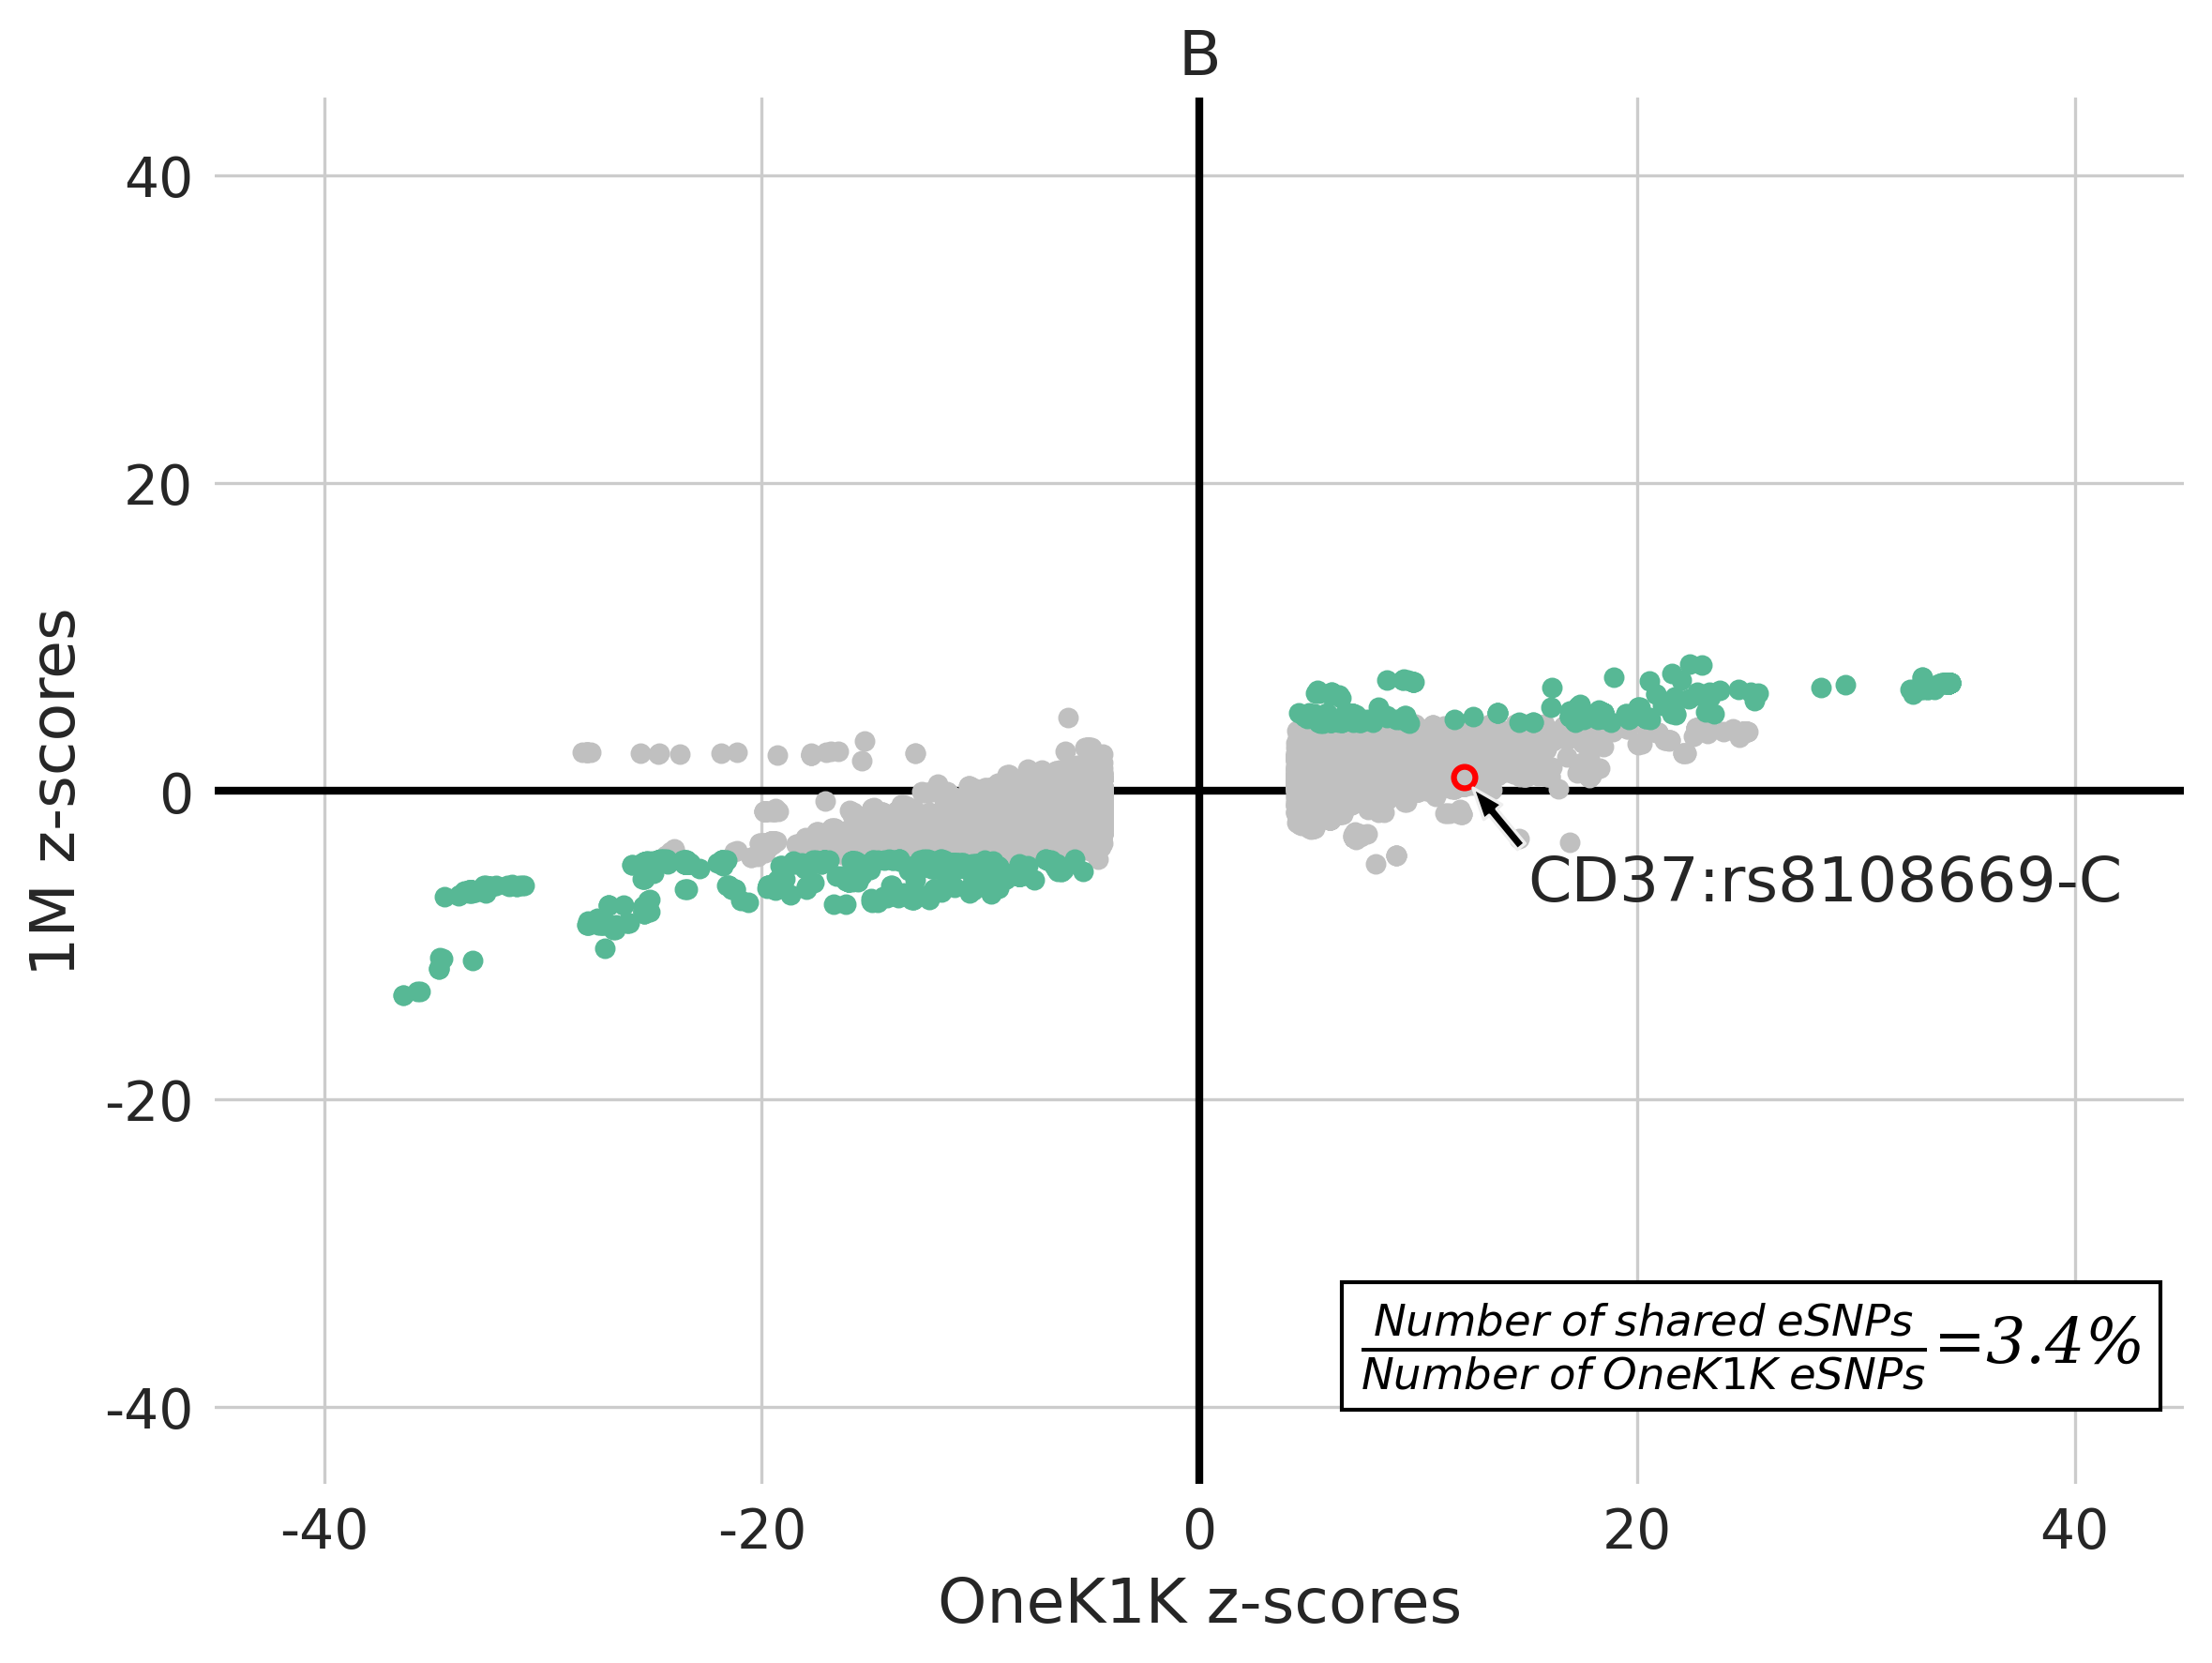

In [354]:
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-whitegrid')
mpl.rcParams['text.usetex'] = False
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_1m_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_1m2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_1m_con, color=c1, s=s)
# mark one snp
ax.scatter(mark_z_1k1k, mark_z, edgecolor='red', facecolor='none', s=s*1.5, linewidth=1.5)
ax.annotate('CD37:rs8108669-C',
            xy=(12.5, 0.2),  # theta, radius
            xytext=(15, -8),    # fraction, fraction
            fontsize=label_font,
            arrowprops=dict(facecolor='black', width=2.5, headwidth=6, headlength=8),
            horizontalalignment='left',
            verticalalignment='bottom',
            )

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)
ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('1M z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'normal',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

In [140]:
### 1m vs 1k1k
## sig: blue
pval_thres = 1e-5
sig_merged_blue_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE < pval_thres)]
sig_merged_only_blue = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE >= pval_thres)]
print(sig_merged_blue_1k1k.shape, sig_merged_only_blue.shape)
# both sig
z_blue = sig_merged_blue_1k1k.Z_BLUE.values
z_1k1k = sig_merged_blue_1k1k.Z_1K1K.values
print(len(z_blue), len(z_1k1k))
concord_ids = np.where((z_blue * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_blue * z_1k1k) < 0)[0]
z_blue_con = z_blue[concord_ids]
z_blue_dis = z_blue[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_blue2 = sig_merged_only_blue.Z_BLUE.values
z_1k1k2 = sig_merged_only_blue.Z_1K1K.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_blue * z_1k1k) >= 0)/len((z_blue * z_1k1k) >= 0)
concord_all = (sum((z_blue * z_1k1k) >= 0) + sum((z_blue2 * z_1k1k2) >= 0)) / (len((z_blue * z_1k1k) >= 0) + len((z_blue2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_blue_1k1k) / (len(sig_merged_blue_1k1k) + len(sig_merged_only_blue))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K1 eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(2997, 21) (4914, 21)
2997 2997
Concordance sig: 98.8%, concordance all: 98.0%
#Shared eSNPs/#OneK1K1 eSNPs: 37.9%


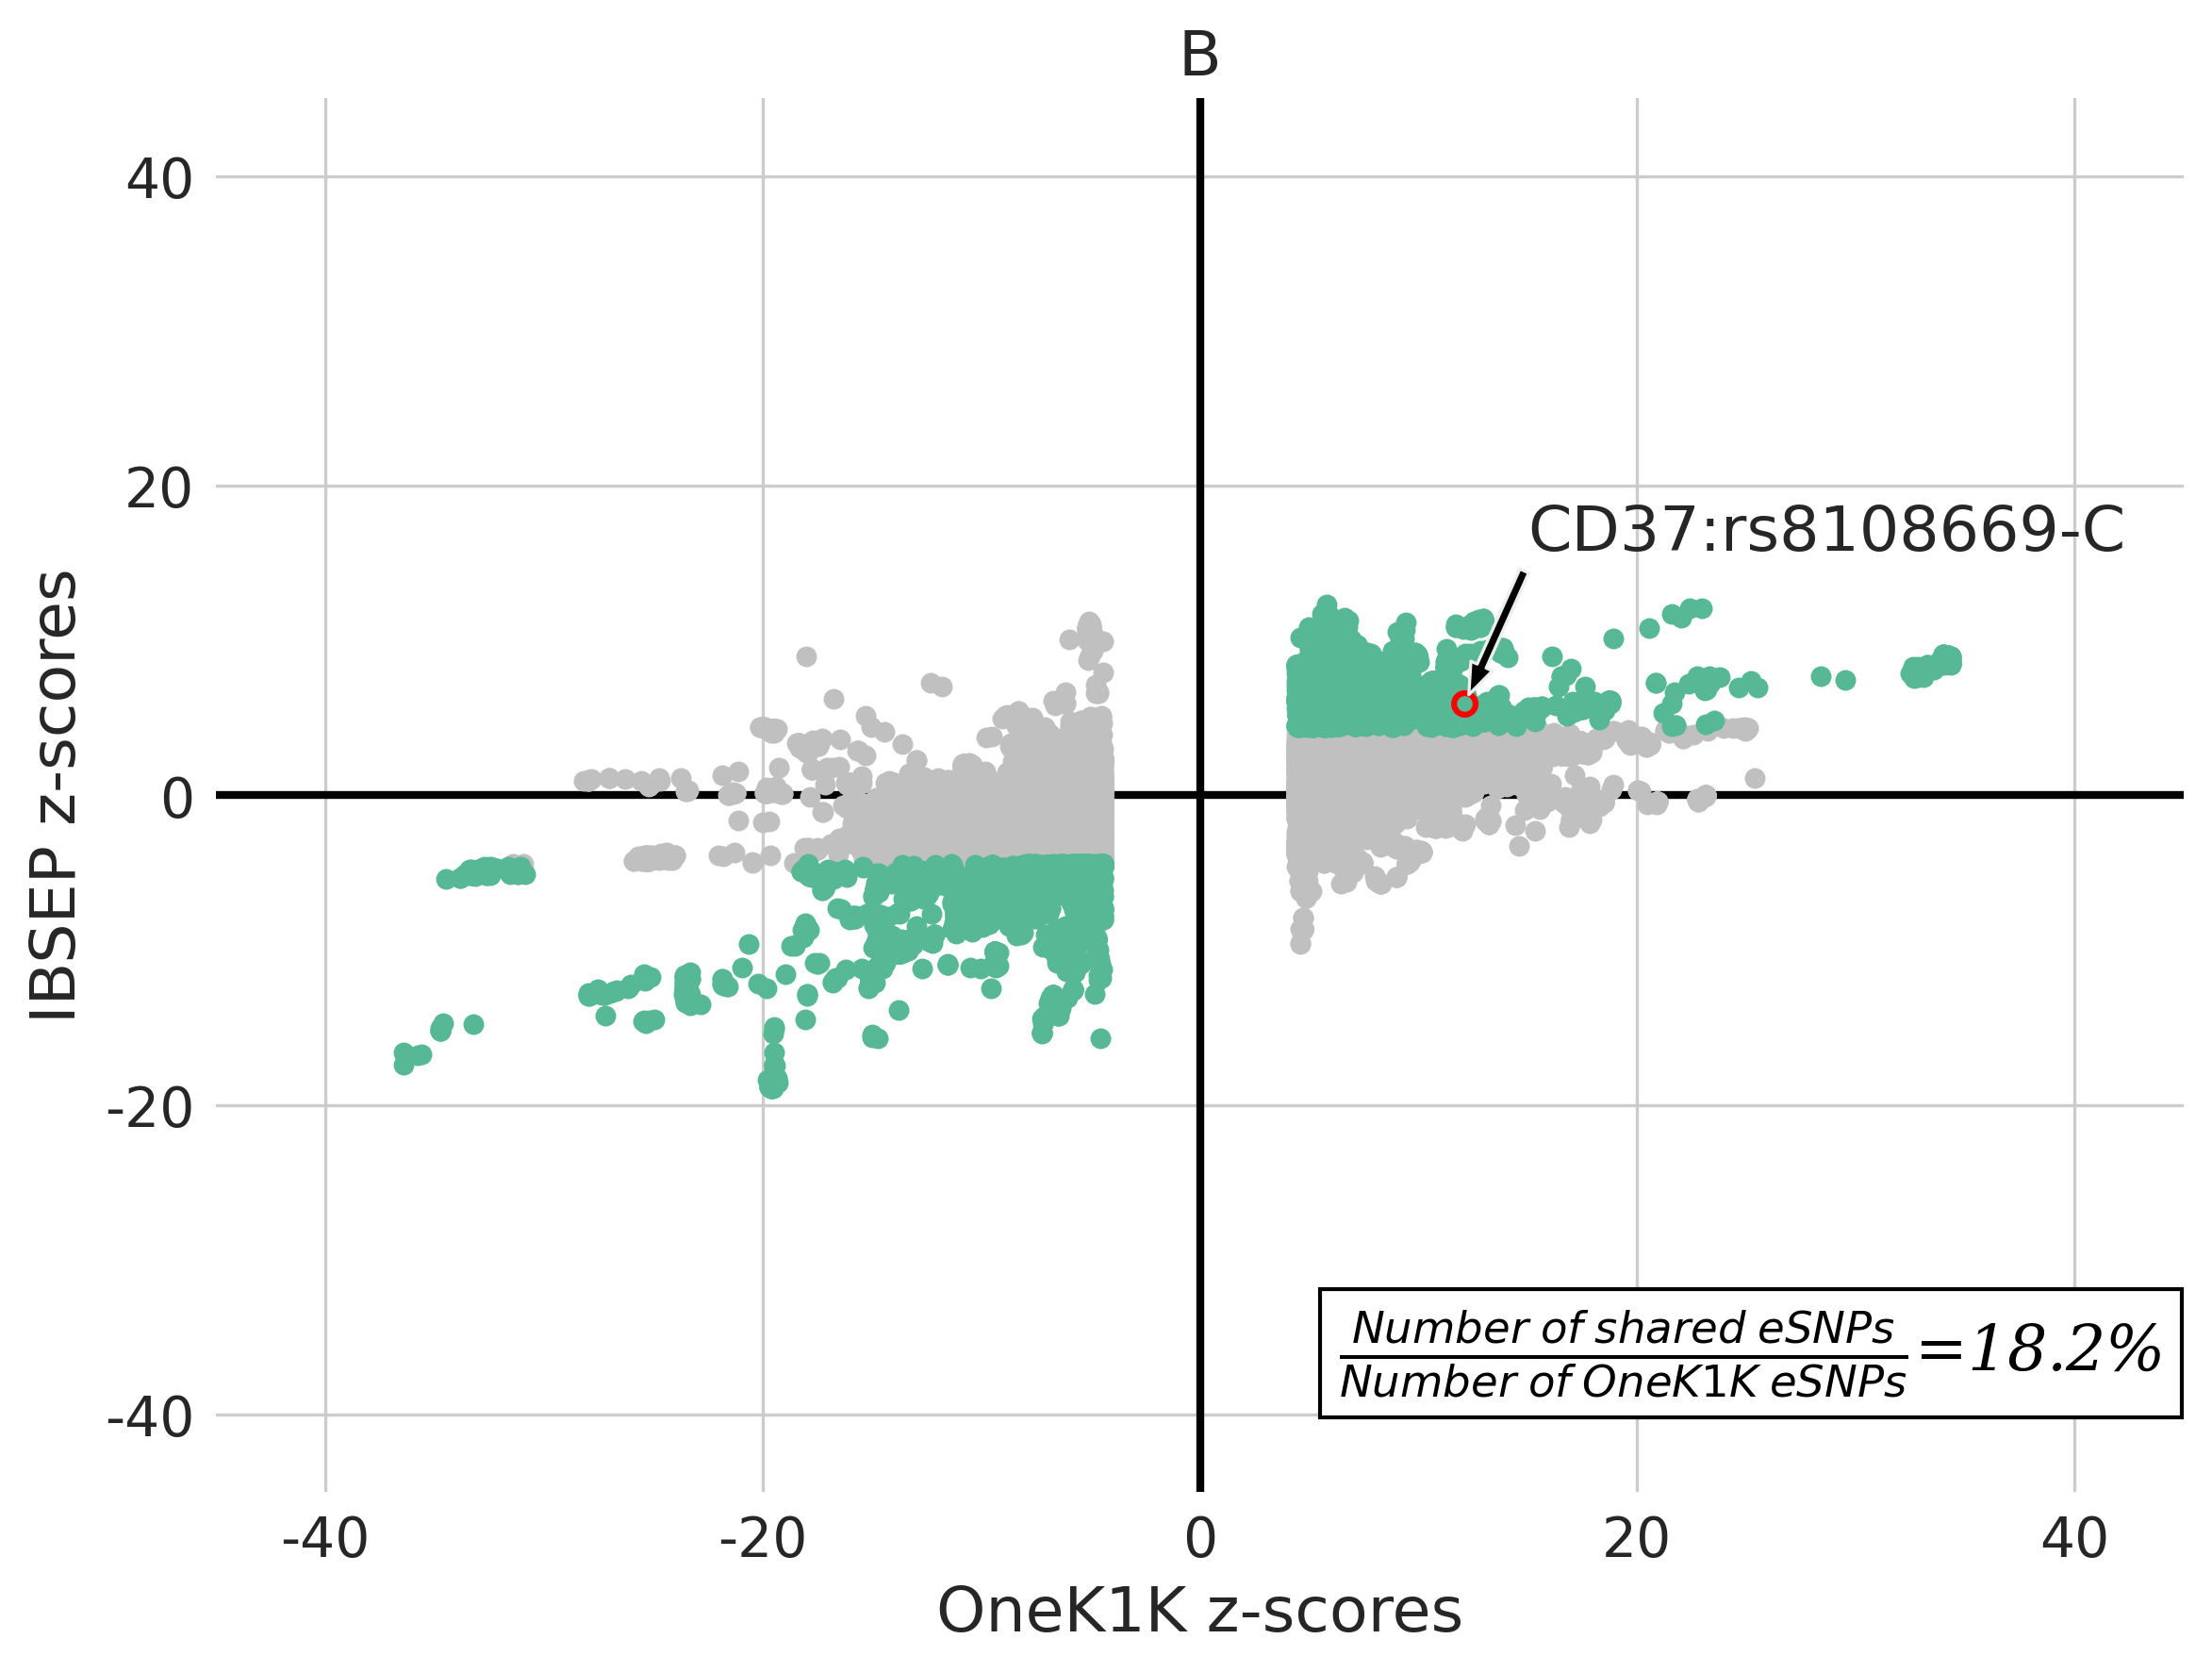

In [352]:
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-whitegrid')
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_blue_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_blue2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_blue_con, color=c1, s=s)
# mark one snp
ax.scatter(mark_z_1k1k, mark_z_blue, edgecolor='red', facecolor='none', s=s*1.5, linewidth=1.5)
ax.annotate('CD37:rs8108669-C',
            xy=(12.3, 6.5),  # theta, radius
            xytext=(15, 15),    # fraction, fraction
            fontsize=label_font,
            arrowprops=dict(facecolor='black', width=2.5, headwidth=6, headlength=8),
            horizontalalignment='left',
            verticalalignment='bottom',
            )


ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)

ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('IBSEP z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'regular',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

## eGenes comparison

In [ ]:
## lowres egenes
stats_lowres = {'1M vs OneK1K':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
                 '1M vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only GTEx genes': {}},
                 '1M vs 1M-Blue':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only 1M-Blue genes': {}},
                 '1M-Blue vs OneK1K':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only OneK1K genes': {}},
                 '1M-Blue vs GTEx':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only GTEx genes': {}}
                }
genes_by_cell_data = {}
for cell_type in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    genes_by_cell_data[cell_type] = {'1M-Blood': [], '1M-Blood-IBSEP': [], 'OneK1K': [], 'GTEx': []}
t0 = time.time()
for cell_type in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    sub_celltypes = celltype_map_1k[cell_type]
    sig_1m_genes, sig_1k_genes, sig_blue_genes, sig_gtex_genes = [], [], [], []
    for sub_celltype in sub_celltypes:
        df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
        merged = pd.merge(df, res_dfs_nonnan[cell_type], on=['SNP_1M', 'GENEID_1M'], how='inner')
        print(f'{sub_celltype}: df {len(df)}, res {len(res_dfs_nonnan[cell_type])}, merged {len(merged)}')
        
        ## significance overlap
        pval_thres = 1e-5
        sig_1m = merged.loc[merged.PVAL_1M < pval_thres]
        sig_1k = merged.loc[merged.PVAL_1K1K < pval_thres]
        sig_blue = merged.loc[merged.PVAL_BLUE < pval_thres]
        sig_gtex = merged.loc[merged.PVAL_GTEX < pval_thres]
        # sig genes
        sig_1m_genes_ = np.unique(sig_1m.GENEID_1M.values)
        sig_1k_genes_ = np.unique(sig_1k.GENEID_1M.values)
        sig_blue_genes_ = np.unique(sig_blue.GENEID_1M.values)
        sig_gtex_genes_ = np.unique(sig_gtex.GENEID_1M.values)
       
        sig_1m_genes.extend(sig_1m_genes_)
        sig_1k_genes.extend(sig_1k_genes_)
        sig_blue_genes.extend(sig_blue_genes_)
        sig_gtex_genes.extend(sig_gtex_genes_)
    sig_1m_genes = list(set(sig_1m_genes))
    sig_1k_genes = list(set(sig_1k_genes))
    sig_blue_genes = list(set(sig_blue_genes))
    sig_gtex_genes = list(set(sig_gtex_genes))
    # save sig genes
    genes_by_cell_data[cell_type]['1M-Blood'] = sig_1m_genes
    genes_by_cell_data[cell_type]['1M-Blood-IBSEP'] = sig_blue_genes
    genes_by_cell_data[cell_type]['OneK1K'] = sig_1k_genes
    genes_by_cell_data[cell_type]['GTEx'] = sig_gtex_genes

    print(f'{cell_type}:')
    sig_common_genes = np.intersect1d(sig_1m_genes, sig_1k_genes)
    sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_1k_genes)
    sig_only_1k_genes = np.setdiff1d(sig_1k_genes, sig_1m_genes)
    stats_lowres['1M vs OneK1K']['Shared genes'][cell_type] = sig_common_genes
    stats_lowres['1M vs OneK1K']['Only 1M genes'][cell_type] = sig_only_1m_genes
    stats_lowres['1M vs OneK1K']['Only OneK1K genes'][cell_type] = sig_only_1k_genes
    print(f'1M vs OneK1K | Common: {len(sig_common_genes)}, Only 1M: {len(sig_only_1m_genes)}, Only 1K1K: {len(sig_only_1k_genes)}')
    sig_common_genes = np.intersect1d(sig_1m_genes, sig_gtex_genes)
    sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_gtex_genes)
    sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_1m_genes)
    stats_lowres['1M vs GTEx']['Shared genes'][cell_type] = sig_common_genes
    stats_lowres['1M vs GTEx']['Only 1M genes'][cell_type] = sig_only_1m_genes
    stats_lowres['1M vs GTEx']['Only GTEx genes'][cell_type] = sig_only_gtex_genes
    print(f'1M vs GTEx | Common: {len(sig_common_genes)}, Only 1M-Blue: {len(sig_only_1m_genes)}, Only GTEx: {len(sig_only_gtex_genes)}\n')

    sig_common_genes = np.intersect1d(sig_1m_genes, sig_blue_genes)
    sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_blue_genes)
    sig_only_blue_genes = np.setdiff1d(sig_blue_genes, sig_1m_genes)
    stats_lowres['1M vs 1M-Blue']['Shared genes'][cell_type] = sig_common_genes
    stats_lowres['1M vs 1M-Blue']['Only 1M genes'][cell_type] = sig_only_1m_genes
    stats_lowres['1M vs 1M-Blue']['Only 1M-Blue genes'][cell_type] = sig_only_blue_genes
    print(f'1M vs 1M-Blue | Common: {len(sig_common_genes)}, Only 1M: {len(sig_only_1m_genes)}, Only 1M-Blue: {len(sig_only_blue_genes)}')
    sig_common_genes = np.intersect1d(sig_1k_genes, sig_blue_genes)
    sig_only_1k_genes = np.setdiff1d(sig_1k_genes, sig_blue_genes)
    sig_only_blue_genes = np.setdiff1d(sig_blue_genes, sig_1k_genes)
    stats_lowres['1M-Blue vs OneK1K']['Shared genes'][cell_type] = sig_common_genes
    stats_lowres['1M-Blue vs OneK1K']['Only OneK1K genes'][cell_type] = sig_only_1k_genes
    stats_lowres['1M-Blue vs OneK1K']['Only 1M-Blue genes'][cell_type] = sig_only_blue_genes
    print(f'1M-Blue vs OneK1K | Common: {len(sig_common_genes)}, Only 1M-Blue: {len(sig_only_blue_genes)}, Only 1K1K: {len(sig_only_1k_genes)}')
    sig_common_genes = np.intersect1d(sig_blue_genes, sig_gtex_genes)
    sig_only_blue_genes = np.setdiff1d(sig_blue_genes, sig_gtex_genes)
    sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_blue_genes)
    stats_lowres['1M-Blue vs GTEx']['Shared genes'][cell_type] = sig_common_genes
    stats_lowres['1M-Blue vs GTEx']['Only 1M-Blue genes'][cell_type] = sig_only_blue_genes
    stats_lowres['1M-Blue vs GTEx']['Only GTEx genes'][cell_type] = sig_only_gtex_genes
    print(f'1M-Blue vs GTEx | Common: {len(sig_common_genes)}, Only 1M-Blue: {len(sig_only_blue_genes)}, Only GTEx: {len(sig_only_gtex_genes)}\n')
t1 = time.time()
print(f'Total time: {t1 - t0:.1f}s')

In [253]:
## save
with open(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/lowres_egenes_1e-5_hij1e-10.json', 'w') as f:
    json.dump(genes_by_cell_data, f)
for k, v in stats_lowres.items():
    for k2, v2 in v.items():
        for k3, v3 in v2.items():
            stats_lowres[k][k2][k3] = v3.tolist()
with open(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/egenes_lowres_1e-5_hij1e-10.json', 'w') as f:
    json.dump(stats_lowres, f)

In [8]:
## load
with open(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/egenes_lowres_1e-5_hij1e-10.json', 'r') as f:
    stats_lowres = json.load(f)
nums_lowres = {'1M vs OneK1K':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
               '1M vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only GTEx genes': {}},
                 '1M vs 1M-Blue':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only 1M-Blue genes': {}},
                 '1M-Blue vs OneK1K':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only OneK1K genes': {}},
                 '1M-Blue vs GTEx':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only GTEx genes': {}}
                }
for k, v, in stats_lowres.items():
    for k2, v2 in v.items():
        for k3, v3 in v2.items():
            nums_lowres[k][k2][k3] = len(v3)

In [10]:
## load
with open(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/lowres_egenes_1e-5_hij1e-10.json', 'r') as f:
    egenes_lowres = json.load(f)
print(egenes_lowres.keys())
print(egenes_lowres['CD4T'].keys())

dict_keys(['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC'])
dict_keys(['1M-Blood', '1M-Blood-IBSEP', 'OneK1K', 'GTEx'])


In [14]:
### egenes vs number of cell types
egenes_vs_cts = dict.fromkeys(sorted_cell_types)
all_egenes_1m, all_egenes_ibsep, all_egenes_1k1k = [], [], []
for ct in sorted_cell_types:
    all_egenes_1m.extend(egenes_lowres[ct]['1M-Blood'])
    all_egenes_ibsep.extend(egenes_lowres[ct]['1M-Blood-IBSEP'])
    all_egenes_1k1k.extend(egenes_lowres[ct]['OneK1K'])
all_egenes_1m = list(set(all_egenes_1m))
all_egenes_ibsep = list(set(all_egenes_ibsep))
all_egenes_1k1k = list(set(all_egenes_1k1k))
print(len(all_egenes_1m), len(all_egenes_ibsep), len(all_egenes_1k1k))

egenes_vs_cts_1m = {k: [] for k in [1,2,3,4,5,6]}
egenes_vs_cts_ibsep = {k: [] for k in [1,2,3,4,5,6]}
egenes_vs_cts_1k1k = {k: [] for k in [1,2,3,4,5,6]}
for gene in all_egenes_1m:
    n = 0
    for ct in sorted_cell_types:
        if gene in egenes_lowres[ct]['1M-Blood']:
            n += 1
    egenes_vs_cts_1m[n].append(gene)
for gene in all_egenes_ibsep:
    n = 0
    for ct in sorted_cell_types:
        if gene in egenes_lowres[ct]['1M-Blood-IBSEP']:
            n += 1
    egenes_vs_cts_ibsep[n].append(gene)
for gene in all_egenes_1k1k:
    n = 0
    for ct in sorted_cell_types:
        if gene in egenes_lowres[ct]['OneK1K']:
            n += 1
    egenes_vs_cts_1k1k[n].append(gene)

col1, col2, col3 = [], [], []
for k, v in egenes_vs_cts_1m.items():
    col1.append(len(v))
for k, v in egenes_vs_cts_ibsep.items():
    col2.append(len(v))
for k, v in egenes_vs_cts_1k1k.items():
    col3.append(len(v))
egenes_vs_cts_df = pd.DataFrame({'#cell types': [1,2,3,4,5,6], '1m': col1, 'ibsep': col2, 'onek1k': col3})
egenes_vs_cts_df

328 1808 1779


,#cell types,1m,ibsep,onek1k
0,1,197,582,670
1,2,52,312,390
2,3,37,274,314
3,4,13,382,226
4,5,12,217,100
5,6,17,41,79


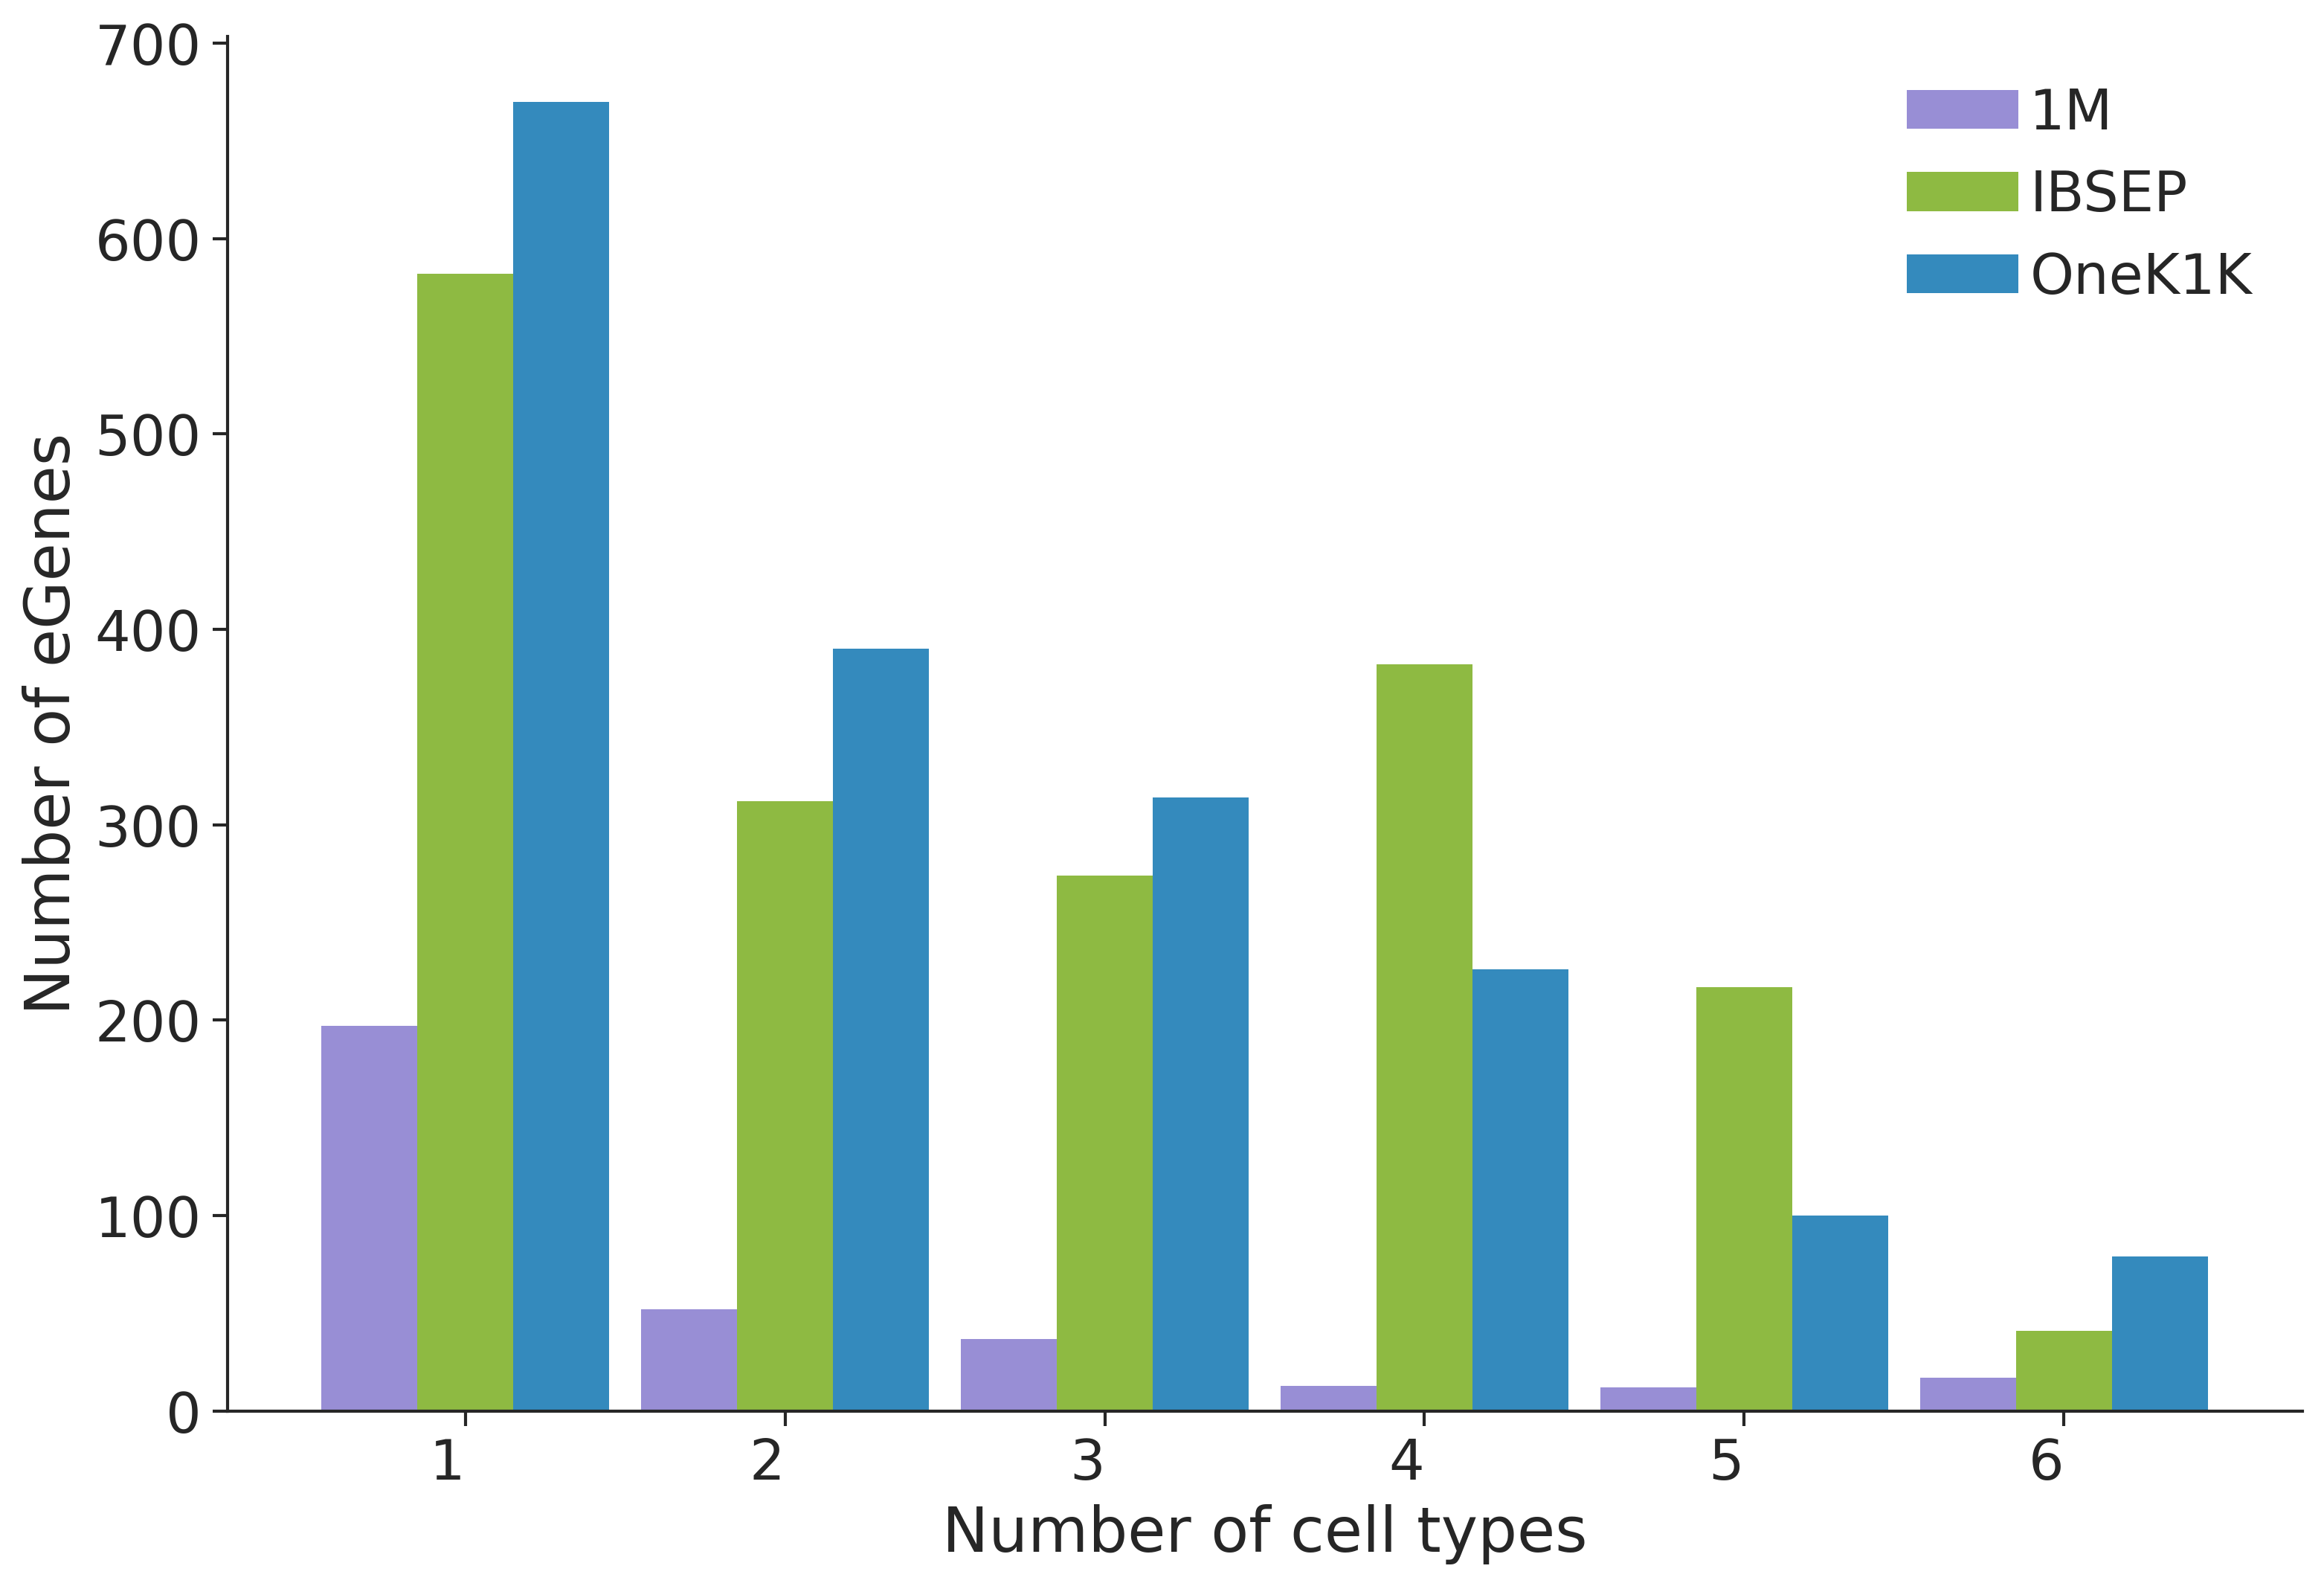

In [25]:
## bar plot: #egenes vs #cell types
style.use('seaborn-white')
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(12, 8), dpi=300)
width = 0.3

bar1 = ax.bar(np.arange(1,7)-width, egenes_vs_cts_df['1m'].values, width=width, color='C2', label='1M')
bar2 = ax.bar(np.arange(1,7)-0*width, egenes_vs_cts_df['ibsep'].values, width=width, color='C5', label='IBSEP')
bar3 = ax.bar(np.arange(1,7)+width, egenes_vs_cts_df['onek1k'].values, width=width, color='C1', label='OneK1K')

ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=18,handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of cell types', fontsize=20)
ax.set_ylabel('Number of eGenes', fontsize=20)
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels([1,2,3,4,5,6], rotation=0, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [ ]:
nums_lowres2 = {'1M vs OneK1K':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
               '1M vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only GTEx genes': {}},
                 '1M vs 1M-Blue':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only 1M-Blue genes': {}},
                 '1M-Blue vs OneK1K':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only OneK1K genes': {}},
                 '1M-Blue vs GTEx':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only GTEx genes': {}},
                'OneK1K vs GTEx':
                {'Shared genes': {}, 'Only OneK1K genes': {}, 'Only GTEx genes': {}}
                }
for ct in egenes_lowres.keys():
    k = '1M vs OneK1K'
    k1 = '1M-Blood'
    k2 = 'OneK1K'
    k1_ = 'Only 1M genes'
    k2_ = 'Only OneK1K genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

    k = '1M vs GTEx'
    k1 = '1M-Blood'
    k2 = 'GTEx'
    k1_ = 'Only 1M genes'
    k2_ = 'Only GTEx genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

    k = '1M vs 1M-Blue'
    k1 = '1M-Blood'
    k2 = '1M-Blood-IBSEP'
    k1_ = 'Only 1M genes'
    k2_ = 'Only 1M-Blue genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

    k = '1M-Blue vs OneK1K'
    k1 = '1M-Blood-IBSEP'
    k2 = 'OneK1K'
    k1_ = 'Only 1M-Blue genes'
    k2_ = 'Only OneK1K genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

    k = '1M-Blue vs GTEx'
    k1 = '1M-Blood-IBSEP'
    k2 = 'GTEx'
    k1_ = 'Only 1M-Blue genes'
    k2_ = 'Only GTEx genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

    k = 'OneK1K vs GTEx'
    k1 = 'OneK1K'
    k2 = 'GTEx'
    k1_ = 'Only OneK1K genes'
    k2_ = 'Only GTEx genes'
    shared = list(set(egenes_lowres[ct][k1]) & set(egenes_lowres[ct][k2]))
    only1 = list(set(egenes_lowres[ct][k1]) - set(egenes_lowres[ct][k2]))
    only2 = list(set(egenes_lowres[ct][k2]) - set(egenes_lowres[ct][k1]))
    nums_lowres2[k]['Shared genes'][ct] = len(shared)
    nums_lowres2[k][k1_][ct] = len(only1)
    nums_lowres2[k][k2_][ct] = len(only2)

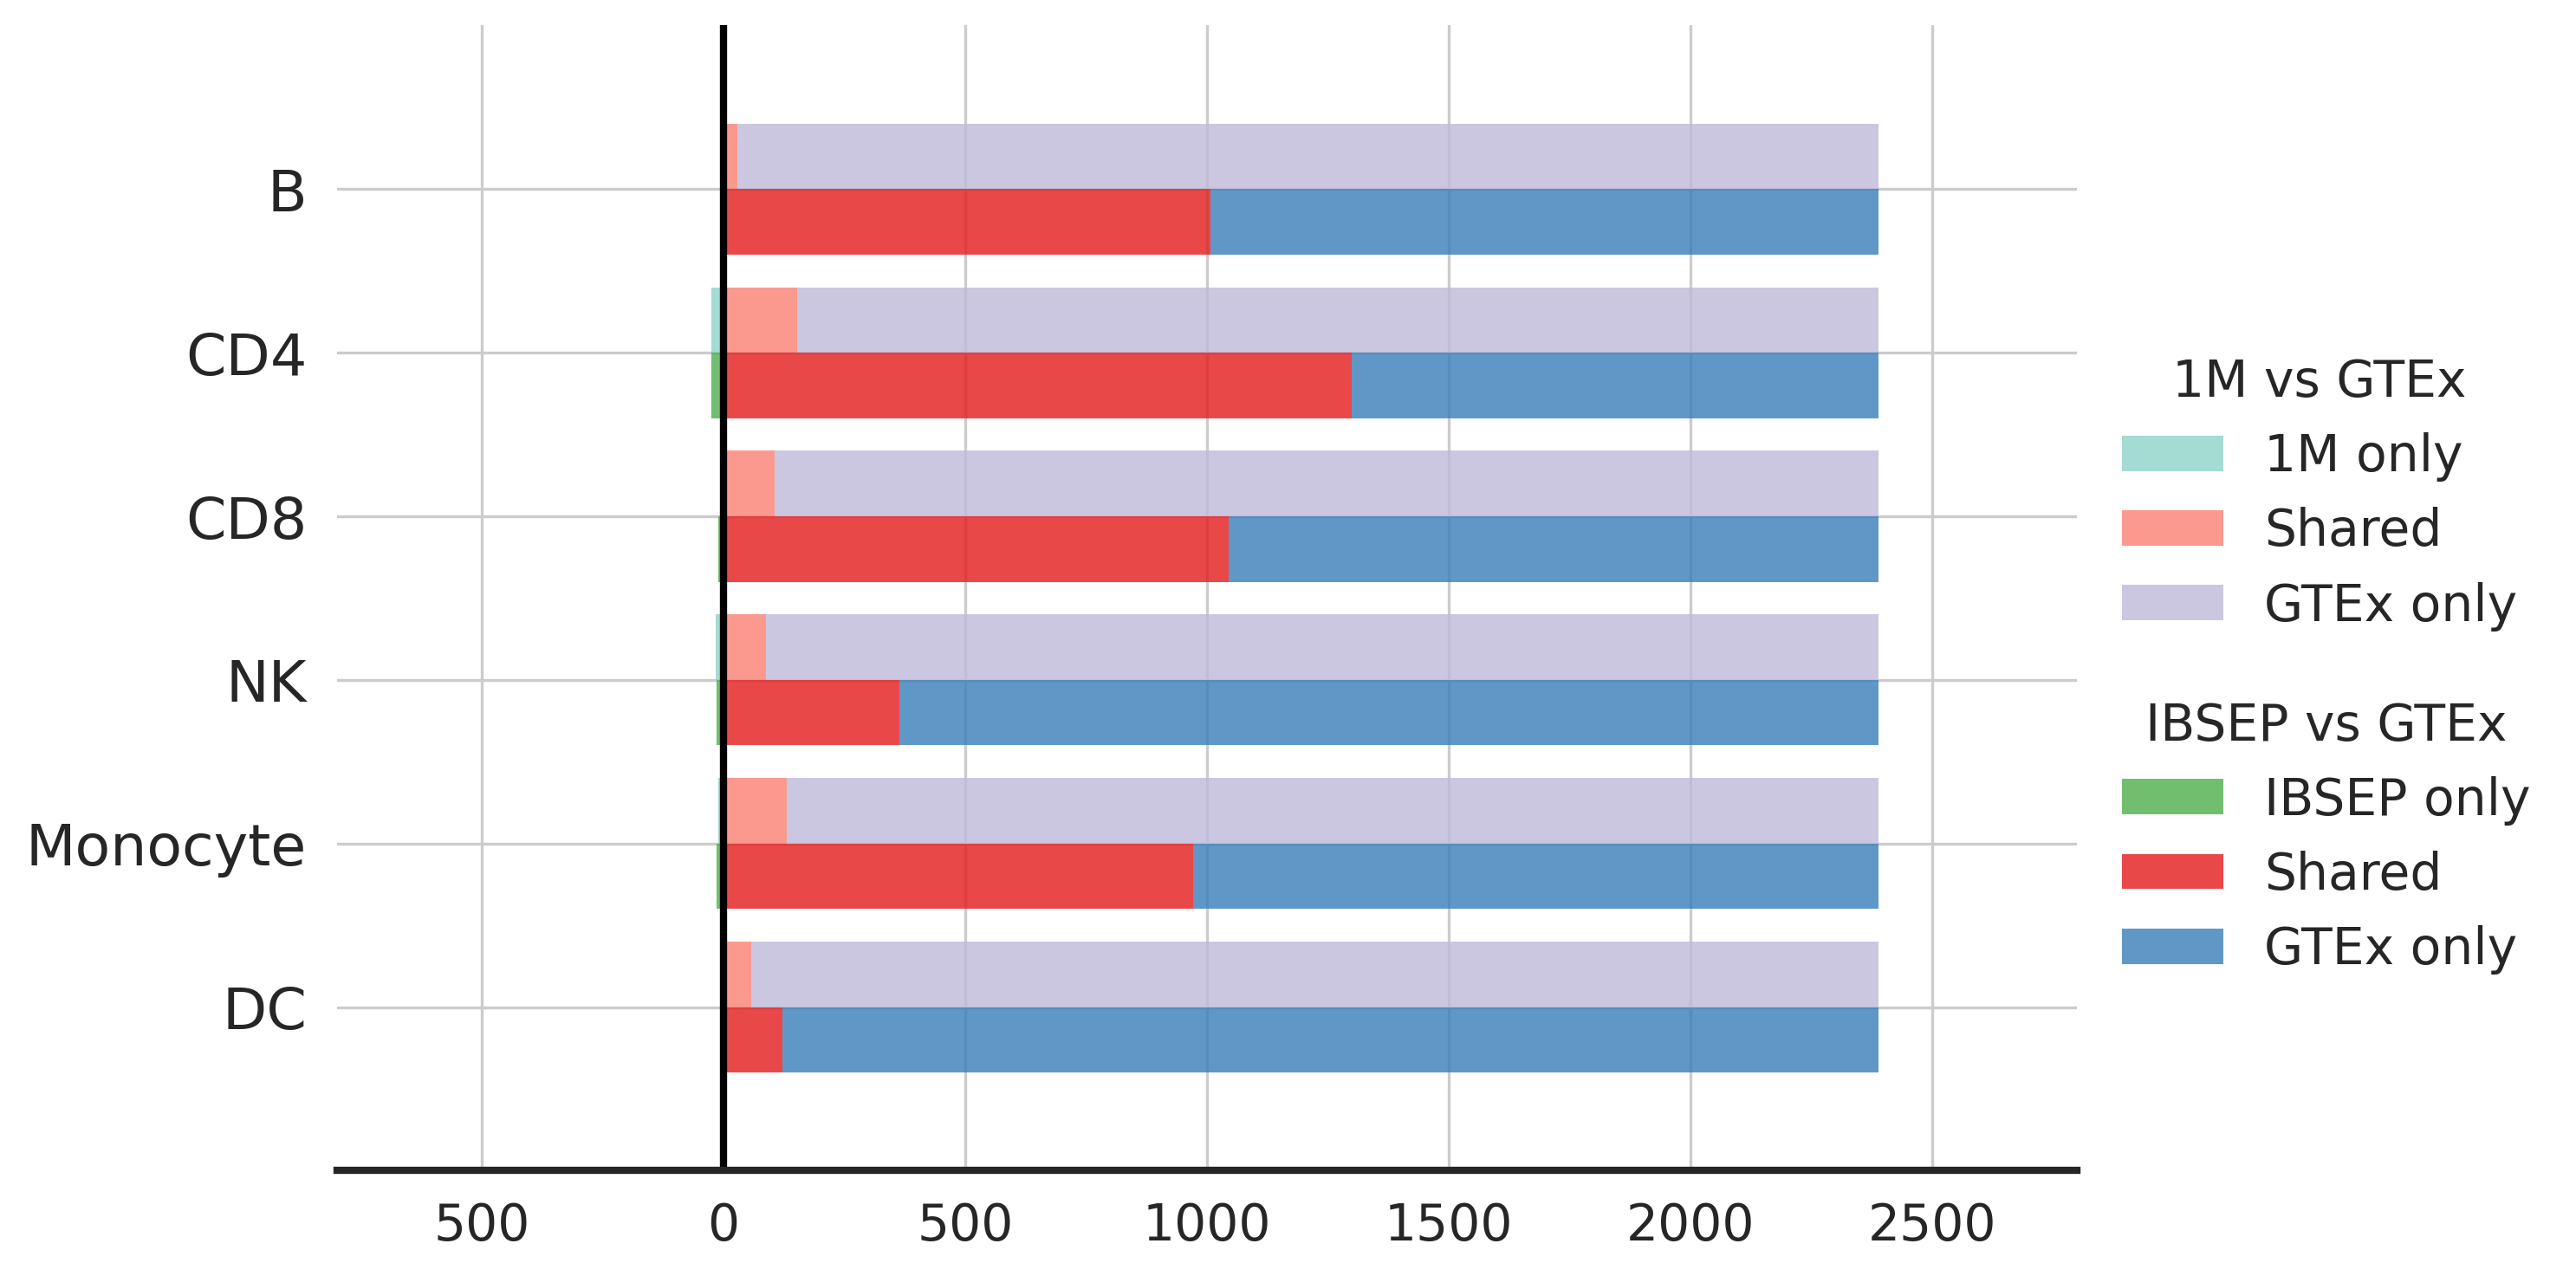

In [124]:
### diverging plot
height = 0.4
tick_font = 14
label_font = 16
lgd_font = 14
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
left = np.zeros(6)
c1 = '#8DD3C7'
c2 = '#4DAF4A'
c3 = '#FB8072'
c4 = '#E41A1C'
c5 = '#BEBADA'
c6 = '#377EB8'
bars1, bars2 = [], []
reorder = np.array([3, 0, 1, 4, 2, 5])[::-1]
alpha1, alpha2 = 0.8,0.8
## novel on the right
tmp = nums_lowres2['1M vs GTEx']['Only 1M genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, -v, height, label='1M only', left=left, 
            color=c1, alpha=alpha1)
bars1.append(p)
tmp = nums_lowres2['1M-Blue vs GTEx']['Only 1M-Blue genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, -v, height, label='IBSEP only', left=left, 
            color=c2, alpha=alpha2)
bars2.append(p)

## shared with 1k1k on the left
left1, left2 = np.zeros(6), np.zeros(6)
tmp = nums_lowres2['1M vs GTEx']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='Shared', left=left1, 
            color=c3, alpha=alpha1)
bars1.append(p)
left1 = v
tmp = nums_lowres2['1M-Blue vs GTEx']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='Shared', left=left2, 
            color=c4, alpha=alpha2)
left2 = v
bars2.append(p)

## 1k1k novel on the left
tmp = nums_lowres2['1M vs GTEx']['Only GTEx genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='GTEx only', left=left1, 
            color=c5, alpha=alpha1)
bars1.append(p)
tmp = nums_lowres2['1M-Blue vs GTEx']['Only GTEx genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='GTEx only', left=left2, 
            color=c6, alpha=alpha2)
bars2.append(p)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(-1, 6)
ax.set_xlim(-800, 2800)
ax.set_xticks([-500, 0, 500, 1000, 1500, 2000, 2500])
ax.set_xticklabels(['500', '0', '500', '1000', '1500', '2000', '2500'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.array(['CD4', 'CD8', 'Monocyte', 'B', 'NK', 'DC'])[reorder], fontsize=label_font)
ax.tick_params(axis='x', which='both', labelsize=tick_font)
ax.tick_params(axis='y', which='both', labelsize=label_font)
ax.axvline(x=0, color='black', lw=2)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
## legend on the right
legend1 = ax.legend(handles=bars1, loc='upper left', bbox_to_anchor=(1, 0.75), fontsize=lgd_font, 
                    title='1M vs GTEx', title_fontsize=lgd_font)
ax.add_artist(legend1)
ax.legend(handles=bars2, loc='upper left', bbox_to_anchor=(1, 0.45), fontsize=lgd_font, title='IBSEP vs GTEx', title_fontsize=lgd_font)


ax.grid(True)
plt.tight_layout()
plt.show()

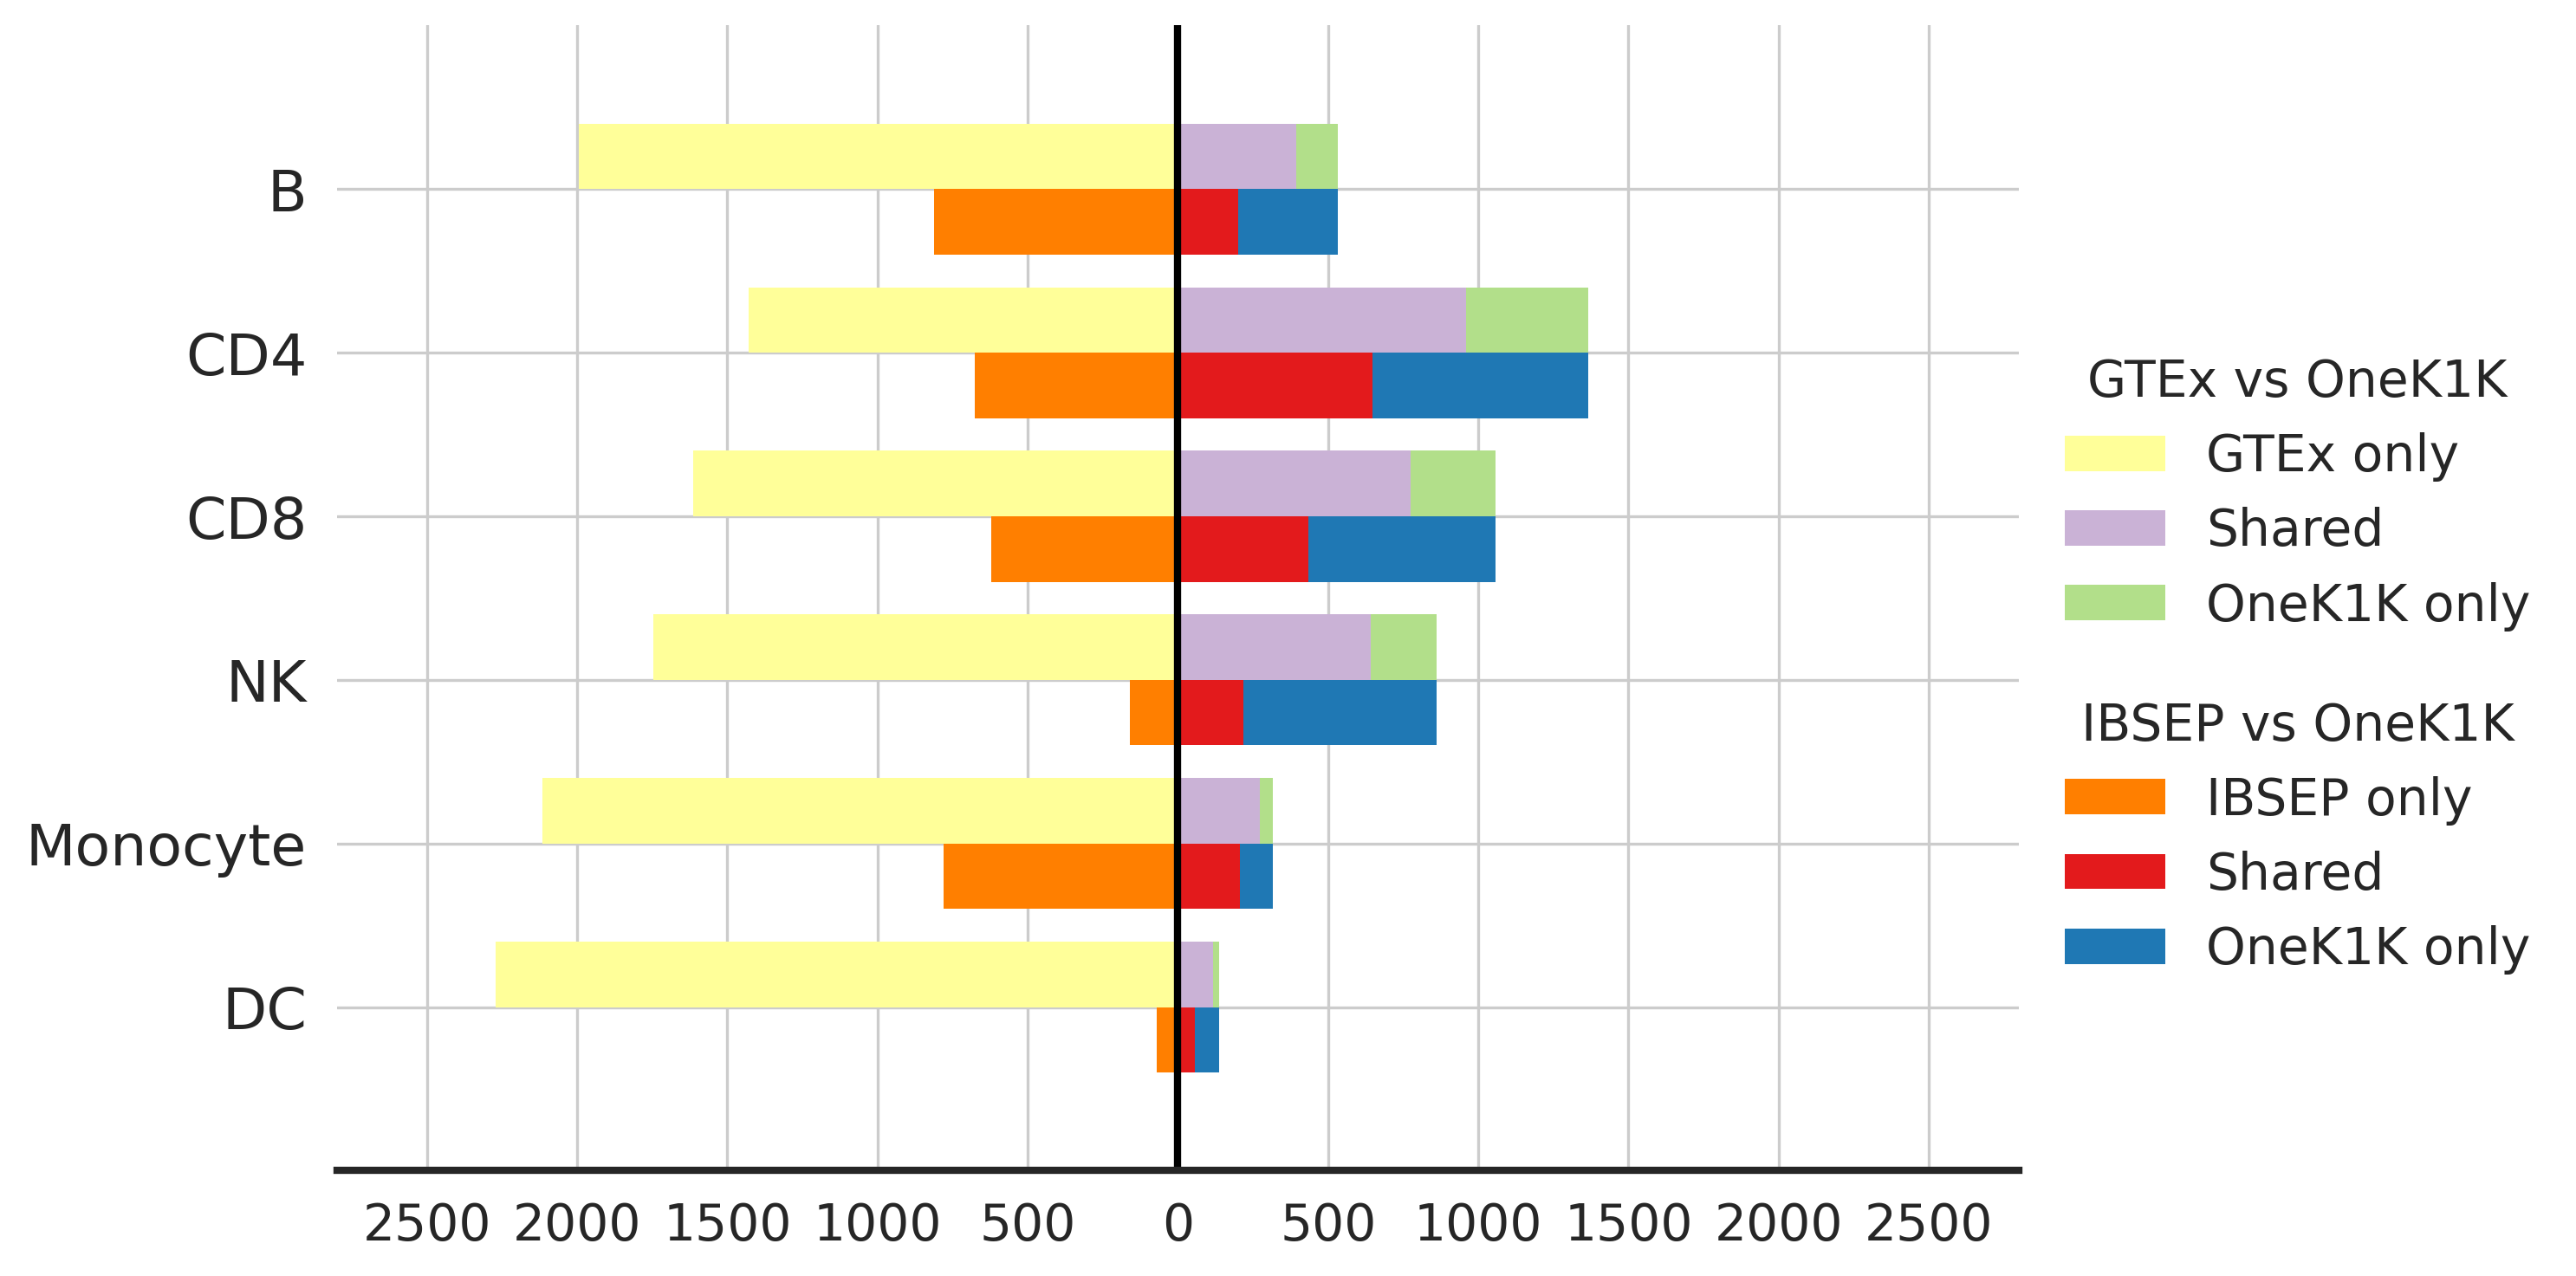

In [30]:
### diverging plot
height = 0.4
tick_font = 14
label_font = 16
lgd_font = 14
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
left = np.zeros(6)
cmap = plt.colormaps['Paired']
bars1, bars2 = [], []
reorder = np.array([3, 0, 1, 4, 2, 5])[::-1]
alpha1, alpha2 = 1, 1
## novel on the right
tmp = nums_lowres2['OneK1K vs GTEx']['Only GTEx genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, -v, height, label='GTEx only', left=left, 
            color=cmap.colors[10], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres2['1M-Blue vs OneK1K']['Only 1M-Blue genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, -v, height, label='IBSEP only', left=left, 
            color=cmap.colors[7], alpha=alpha2)
bars2.append(p)

## shared with 1k1k on the left
left1, left2 = np.zeros(6), np.zeros(6)
tmp = nums_lowres2['OneK1K vs GTEx']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='Shared', left=left1, 
            color=cmap.colors[8], alpha=alpha1)
bars1.append(p)
left1 = v
tmp = nums_lowres2['1M-Blue vs OneK1K']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='Shared', left=left2, 
            color=cmap.colors[5], alpha=alpha2)
left2 = v
bars2.append(p)

## 1k1k novel on the left
tmp = nums_lowres2['OneK1K vs GTEx']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='OneK1K only', left=left1, 
            color=cmap.colors[2], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres2['1M-Blue vs OneK1K']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='OneK1K only', left=left2, 
            color=cmap.colors[1], alpha=alpha2)
bars2.append(p)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-2800, 2800)
ax.set_ylim(-1, 6)
ax.set_xticks([-2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500])
ax.set_xticklabels(['2500', '2000', '1500', '1000', '500', '0', '500', '1000', '1500', '2000', '2500'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.array(['CD4', 'CD8', 'Monocyte', 'B', 'NK', 'DC'])[reorder], fontsize=label_font)
ax.tick_params(axis='x', which='both', labelsize=tick_font)
ax.tick_params(axis='y', which='both', labelsize=label_font)
ax.axvline(x=0, color='black', lw=2)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
## legend on the right
legend1 = ax.legend(handles=bars1, loc='upper left', bbox_to_anchor=(1, 0.75), fontsize=lgd_font, 
                    title='GTEx vs OneK1K', title_fontsize=lgd_font)
ax.add_artist(legend1)
ax.legend(handles=bars2, loc='upper left', bbox_to_anchor=(1, 0.45), fontsize=lgd_font, title='IBSEP vs OneK1K', title_fontsize=lgd_font)


ax.grid(True)
plt.tight_layout()
plt.show()

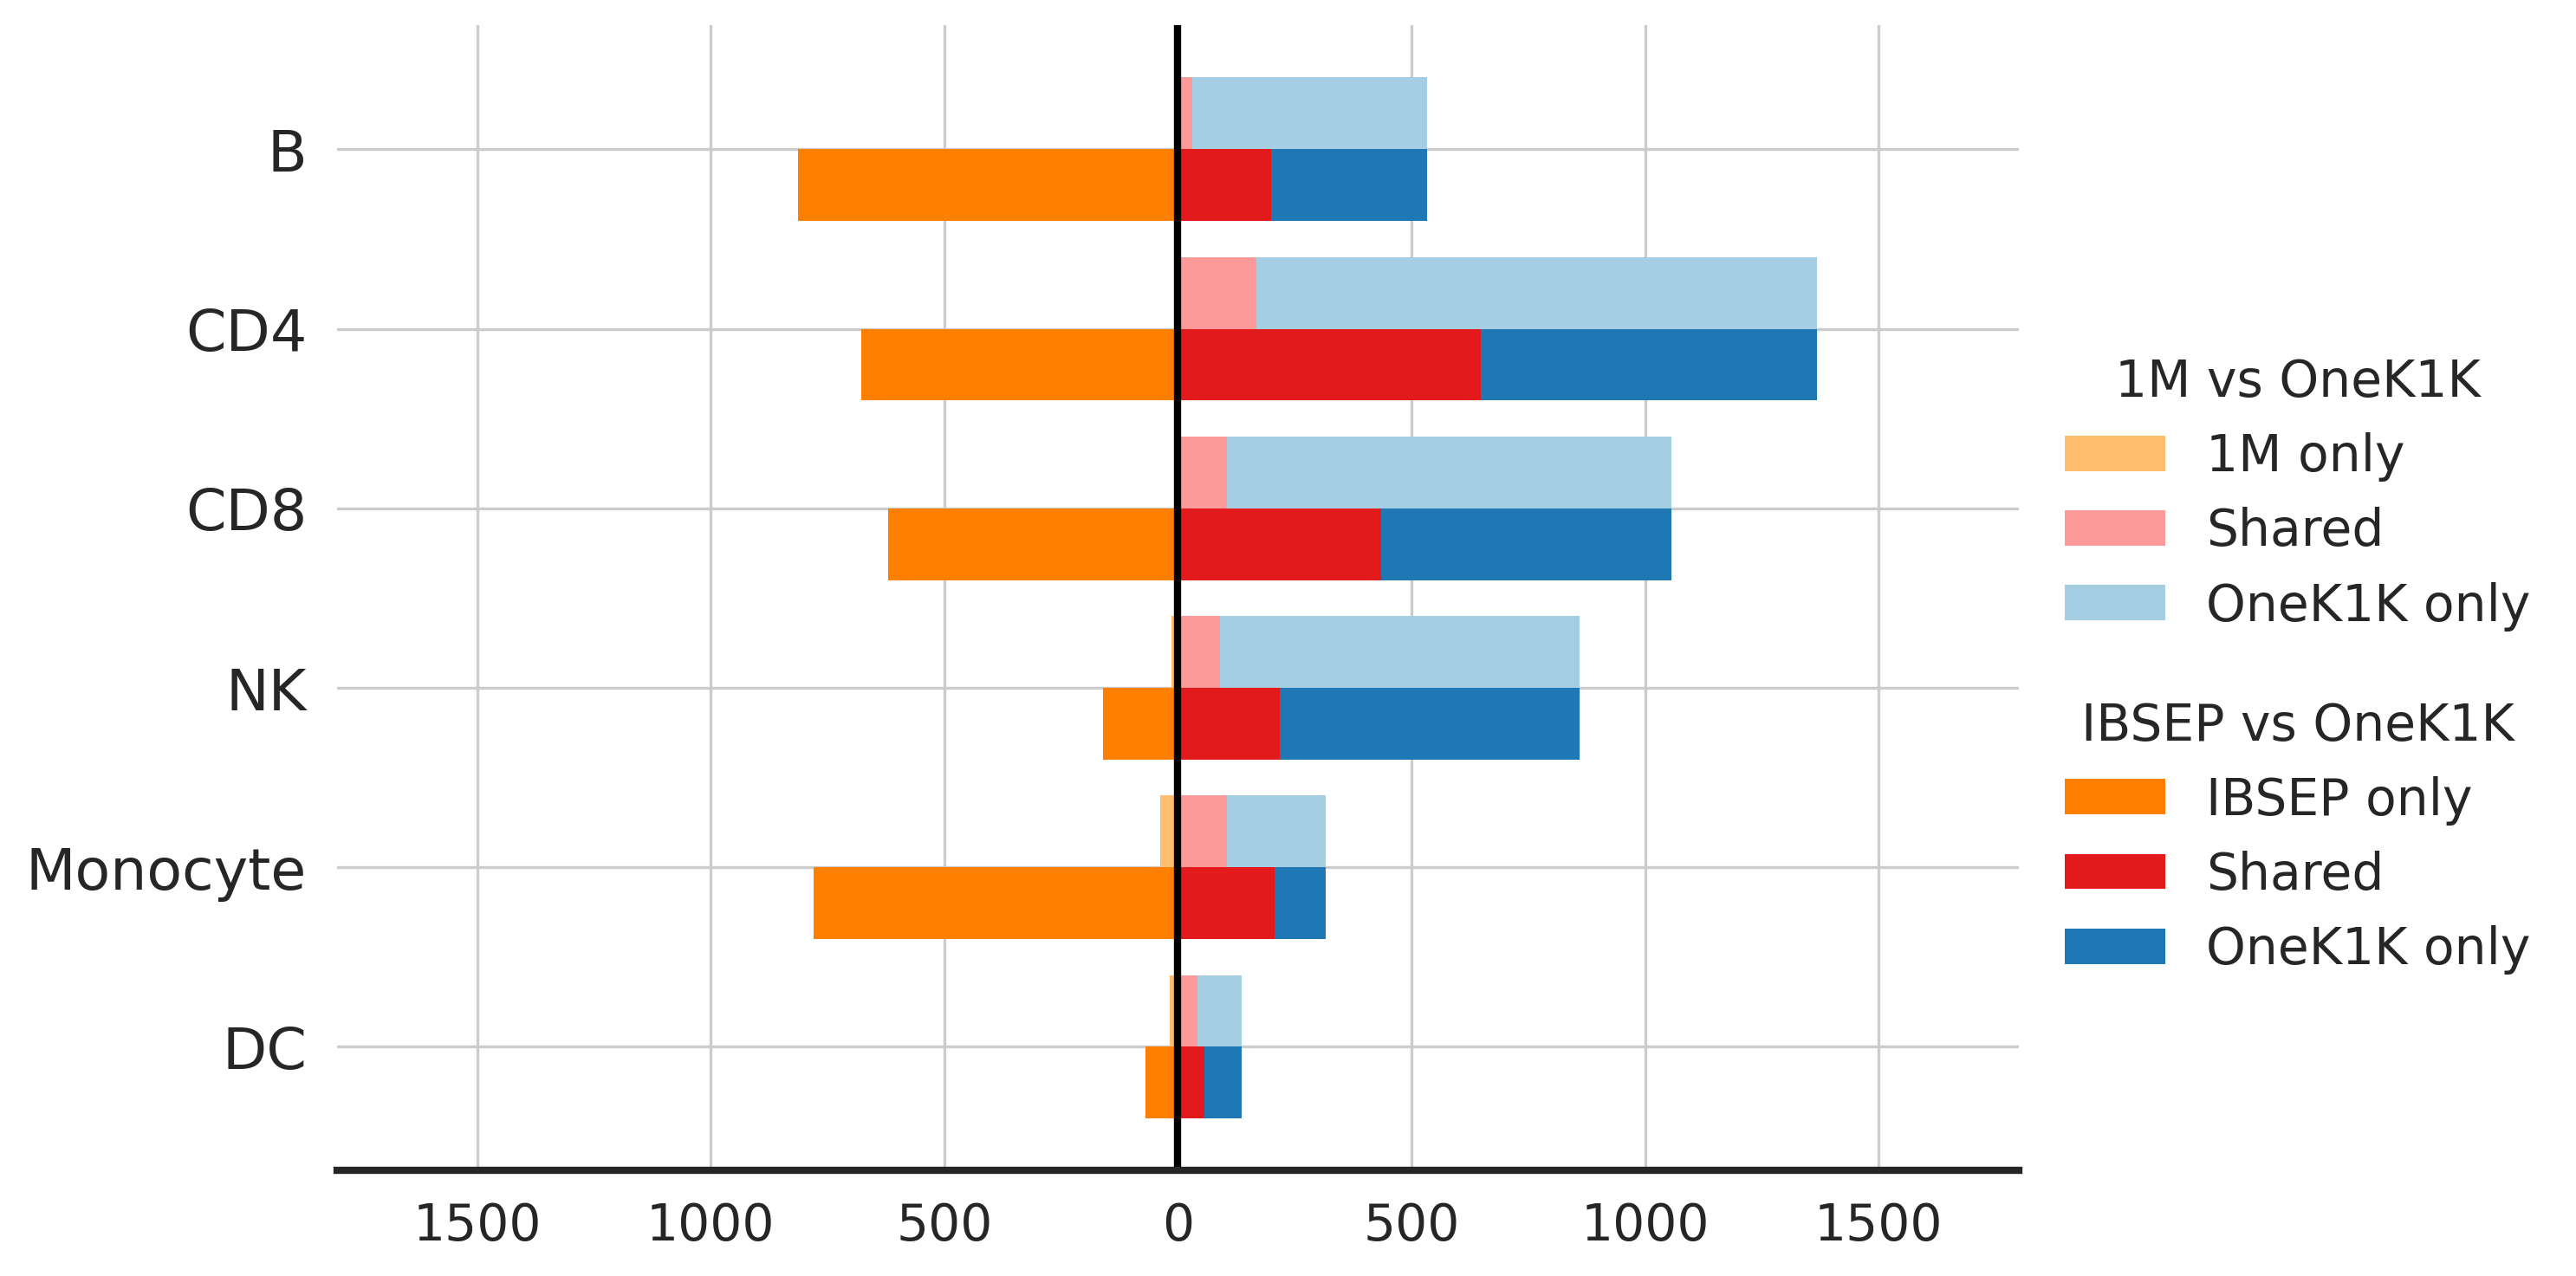

In [9]:
### diverging plot
height = 0.4
tick_font = 14
label_font = 16
lgd_font = 14
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
left = np.zeros(6)
cmap = plt.colormaps['Paired']
bars1, bars2 = [], []
labels = {'Only 1M genes': 'Only 1M-scBlood', 'Only 1M-Blue genes': 'Only 1M-scBlood-IBSEP'}
reorder = np.array([3, 0, 1, 4, 2, 5])[::-1]
alpha1, alpha2 = 1, 1
## novel on the left
tmp = nums_lowres['1M vs OneK1K']['Only 1M genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, -v, height, label='1M only', left=left, 
            color=cmap.colors[6], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres['1M-Blue vs OneK1K']['Only 1M-Blue genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, -v, height, label='IBSEP only', left=left, 
            color=cmap.colors[7], alpha=alpha2)
bars2.append(p)

## shared with 1k1k on the right
left1, left2 = np.zeros(6), np.zeros(6)
tmp = nums_lowres['1M vs OneK1K']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='Shared', left=left1, 
            color=cmap.colors[4], alpha=alpha1)
bars1.append(p)
left1 = v
tmp = nums_lowres['1M-Blue vs OneK1K']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='Shared', left=left2, 
            color=cmap.colors[5], alpha=alpha2)
left2 = v
bars2.append(p)

## 1k1k novel on the right
tmp = nums_lowres['1M vs OneK1K']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)+0.5*height, v, height, label='OneK1K only', left=left1, 
            color=cmap.colors[0], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres['1M-Blue vs OneK1K']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(6)-0.5*height, v, height, label='OneK1K only', left=left2, 
            color=cmap.colors[1], alpha=alpha2)
bars2.append(p)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-1800, 1800)
ax.set_xticks([-1500, -1000, -500, 0, 500, 1000, 1500])
ax.set_xticklabels(['1500', '1000', '500', '0', '500', '1000', '1500'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.array(['CD4', 'CD8', 'Monocyte', 'B', 'NK', 'DC'])[reorder], fontsize=label_font)
ax.tick_params(axis='x', which='both', labelsize=tick_font)
ax.tick_params(axis='y', which='both', labelsize=label_font)
ax.axvline(x=0, color='black', lw=2)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
## legend on the right
legend1 = ax.legend(handles=bars1, loc='upper left', bbox_to_anchor=(1, 0.75), fontsize=lgd_font, 
                    title='1M vs OneK1K', title_fontsize=lgd_font)
ax.add_artist(legend1)
ax.legend(handles=bars2, loc='upper left', bbox_to_anchor=(1, 0.45), fontsize=lgd_font, title='IBSEP vs OneK1K', title_fontsize=lgd_font)


ax.grid(True)
plt.tight_layout()
plt.show()

## Shared significance test

In [31]:
with open(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/lowres_total_genes.json', 'r') as f:
    genes_lowres = json.load(f)

In [168]:
## total number of genes
genes_lowres = dict.fromkeys(sorted_cell_types)
for ct in sorted_cell_types:
    df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/allchroms_{ct}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
    tmp = df.GENEID_1M.unique().tolist()
    print(ct, len(tmp))
    genes_lowres[ct] = tmp

B 5301
CD4T 5301
CD8T 5301
NK 5301
monocyte 5301
DC 5301


In [93]:
## ibsep vs onek1k
nums_dict = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_IBSEP': []}
for ct in sorted_cell_names.keys():
    nums_dict['Cell_type'].append(ct)
    nums_dict['Total'].append(len(genes_lowres[ct]))
    nums_dict['Only_OneK1K'].append(nums_lowres2['1M-Blue vs OneK1K']['Only OneK1K genes'][ct])
    nums_dict['Shared'].append(nums_lowres2['1M-Blue vs OneK1K']['Shared genes'][ct])
    nums_dict['Only_IBSEP'].append(nums_lowres2['1M-Blue vs OneK1K']['Only 1M-Blue genes'][ct])

## gtex vs onek1k
nums_dict2 = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_GTEx': []}
for ct in sorted_cell_names.keys():
    nums_dict2['Cell_type'].append(ct)
    nums_dict2['Total'].append(len(genes_lowres[ct]))
    nums_dict2['Only_OneK1K'].append(nums_lowres2['OneK1K vs GTEx']['Only OneK1K genes'][ct])
    nums_dict2['Shared'].append(nums_lowres2['OneK1K vs GTEx']['Shared genes'][ct])
    nums_dict2['Only_GTEx'].append(nums_lowres2['OneK1K vs GTEx']['Only GTEx genes'][ct])

## gtex vs onek1k
nums_dict3 = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_1M': []}
for ct in sorted_cell_names.keys():
    nums_dict3['Cell_type'].append(ct)
    nums_dict3['Total'].append(len(genes_lowres[ct]))
    nums_dict3['Only_OneK1K'].append(nums_lowres2['1M vs OneK1K']['Only OneK1K genes'][ct])
    nums_dict3['Shared'].append(nums_lowres2['1M vs OneK1K']['Shared genes'][ct])
    nums_dict3['Only_1M'].append(nums_lowres2['1M vs OneK1K']['Only 1M genes'][ct])


In [94]:
nums_df = pd.DataFrame(nums_dict)
nums_df2 = pd.DataFrame(nums_dict2)
nums_df3 = pd.DataFrame(nums_dict3)
nums_df

,Cell_type,Total,Only_OneK1K,Shared,Only_IBSEP
0,B,5301,333,200,813
1,CD4T,5301,718,649,677
2,CD8T,5299,621,435,621
3,NK,5299,642,218,160
4,monocyte,5298,110,207,780
5,DC,5300,80,57,70


In [95]:
nums_df2

,Cell_type,Total,Only_OneK1K,Shared,Only_GTEx
0,B,5301,140,393,1996
1,CD4T,5301,408,959,1430
2,CD8T,5299,282,774,1615
3,NK,5299,219,641,1748
4,monocyte,5298,44,273,2116
5,DC,5300,20,117,2272


In [96]:
nums_df3

,Cell_type,Total,Only_OneK1K,Shared,Only_1M
0,B,5301,503,30,1
1,CD4T,5301,1199,168,9
2,CD8T,5299,952,104,9
3,NK,5299,770,90,14
4,monocyte,5298,213,104,37
5,DC,5300,95,42,18


In [41]:
## ibsep shared prop
p_shared_by_cell = dict.fromkeys(nums_df.Cell_type.values)
for k in p_shared_by_cell.keys():
    p_shared_by_cell[k] = nums_df.loc[nums_df.Cell_type==k].Shared.values[0] / (nums_df.loc[nums_df.Cell_type==k].Shared.values[0] + nums_df.loc[nums_df.Cell_type==k].Only_IBSEP.values[0])

## gtex shared prop
p_shared_by_cell2 = dict.fromkeys(nums_df2.Cell_type.values)
for k in p_shared_by_cell.keys():
    p_shared_by_cell2[k] = nums_df2.loc[nums_df2.Cell_type==k].Shared.values[0] / (nums_df2.loc[nums_df2.Cell_type==k].Shared.values[0] + nums_df2.loc[nums_df2.Cell_type==k].Only_GTEx.values[0])

print(p_shared_by_cell, '\n')
print(p_shared_by_cell2)

{'B': 0.19743336623889438, 'CD4T': 0.4894419306184012, 'CD8T': 0.4119318181818182, 'NK': 0.5767195767195767, 'monocyte': 0.20972644376899696, 'DC': 0.44881889763779526} 

{'B': 0.1645039765592298, 'CD4T': 0.40142318961908746, 'CD8T': 0.32398493093344494, 'NK': 0.26831310171619926, 'monocyte': 0.1142737547090833, 'DC': 0.04897446630389284}


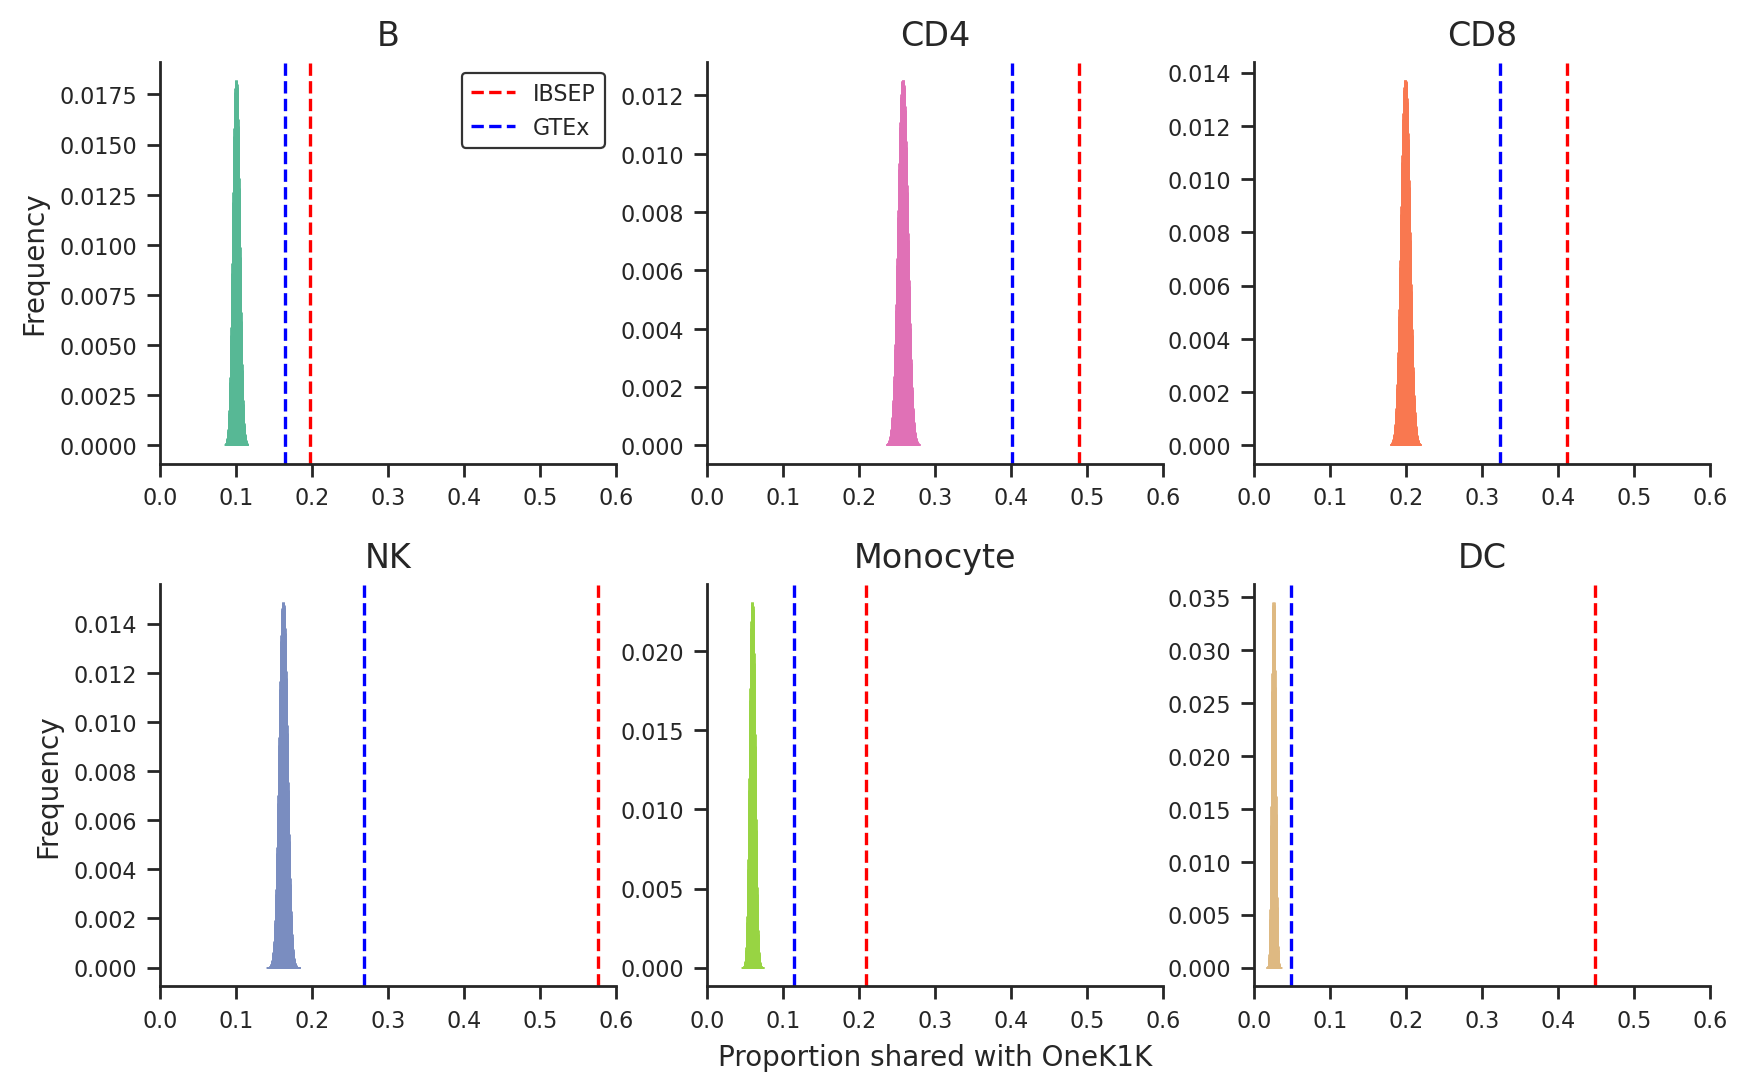

In [59]:
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
sns.set_context('paper',font_scale=1.25)
fig, ax = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
n = 0
for i in range(2):
    for j in range(3):
        ct = list(sorted_cell_names.keys())[n]
        N = nums_df.loc[nums_df.Cell_type==ct, 'Total'].values[0]
        x = np.arange(0, N+1)
        p = (nums_df.loc[nums_df.Cell_type==ct, 'Only_OneK1K'].values[0] + nums_df.loc[nums_df.Cell_type==ct, 'Shared'].values[0]) / N
        y = ss.binom.pmf(x, N, p)
        ax[i,j].vlines(x/N, 0, y, colors=colors[n], linestyles='-', lw=1)
        ax[i,j].axvline(x=p_shared_by_cell[ct], linestyle='--', color='red', label='IBSEP')
        ax[i,j].axvline(x=p_shared_by_cell2[ct], linestyle='--', color='blue', label='GTEx')
        ax[i,j].set_xlim([0, 0.6])
        ax[i,j].set_title(sorted_cell_names[ct])
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        n += 1
        ax[i,j].tick_params(axis='both', which='major', labelsize=8)
        if n == 1:
            ax[i,j].legend(loc='upper right', fontsize=8, frameon=True, fancybox=True, edgecolor='black')
            # ax[i,j].legend(loc='upper right', fontsize=7, title='Prop. shared \nwith OneK1K', title_fontsize=8,
            #               frameon=True, fancybox=True, edgecolor='black')
        if j == 0:
            ax[i,j].set_ylabel('Frequency', fontsize=10)
        if i == 1 and j == 1:
            ax[i,j].set_xlabel('Proportion shared with OneK1K', fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
plt.show()

## Effective sample size

In [ ]:
corr_method = 'truncorr'
omega_shrink = 0.9
hij_pval_thres = 1e-10
all_cell_types = ['B', 'CD4T', 'CD8T', 'DC', 'monocyte', 'NK']
N_all, Neff_all, Neff_new_all, Neff_f_all = {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}
t0 = time.time()
for chrom in range(1, 23):
    files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/*gtex.csv')
    gene_ids = [x.split('/')[-1].split('_')[0] for x in files]
    gene_ids = [x for x in gene_ids if x.startswith('ENSG')]
    Ns_, Neffs_, Neff_news_, Neff_fs_ = [], [], [], []
    for gene_id in tqdm(gene_ids):
        if not os.path.exists(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_Omega_Sigma.npz'):
            continue
        est = np.load(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_Omega_Sigma.npz')
        
        cell_types = est['cell_types']

        Ns, Neffs, Neff_news, Neff_fs = [], [], [], []
        for i, cell_type in enumerate(cell_types):
            try:
                df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_{cell_type}_blue_pval{hij_pval_thres}_tau1.0_{corr_method}.csv', sep='\t')
                ori = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_gtex_withld.csv', sep='\t')
                if omega_shrink < 1:
                    if 'shrinkOmega' in est.files:
                        hsq = np.diag(est['shrinkOmega'])[i]
                    else:
                        hsq = np.diag(est['oriOmega'])[i]
                else:
                    if 'pdOmega' in est.files:
                        hsq = np.diag(est['pdOmega'])[i]
                    else:
                        hsq = np.diag(est['oriOmega'])[i]
                if hsq < 1e-2:
                    continue
                M = len(df)
                if M < 100:
                    continue
                ld_mean = ori.LD.values.mean()
                N = (1 / df.SE ** 2).mean()
    
                Zsq_mean = ((df.BETA / df.SE) ** 2).mean()
                Neff = M * (Zsq_mean - 1) / (hsq * ld_mean)
                Zsq_blue_mean = ((df.BETA_BLUE / df.SE_BLUE) ** 2).mean()
                Neff_new = M * (Zsq_blue_mean - 1) / (hsq * ld_mean)
                Neff_f = (Zsq_blue_mean - 1) / (Zsq_mean - 1)
                if Zsq_mean < 1 or Zsq_blue_mean < 1:
                    continue
    
                N_all[cell_type].append(int(N))
                Neff_all[cell_type].append(int(Neff))
                Neff_new_all[cell_type].append(int(Neff_new))
                Neff_f_all[cell_type].append(Neff_f)
            except Exception as e:
                print(f'Error {e}: {gene_id} {cell_type}')
                continue
    for cell_type in all_cell_types:
        print(f'{cell_type} CHR 1-{chrom}: median Ns {np.median(N_all[cell_type]):.1f}, Neffs {np.median(Neff_all[cell_type]):.1f}, Neff_news {np.median(Neff_new_all[cell_type]):.1f}, Neff_f {np.median(Neff_f_all[cell_type]):.1f}')
        t1 = time.time()
print(f'Time: {t1 - t0:.1f}s')

In [63]:
sample_sizes = {'N': N_all, 'Neff': Neff_all, 'Neff_new': Neff_new_all, 'Neff_f': Neff_f_all}
with open(f'../blood_data/1M/merged_sumstats/by_chrom_gene/effective_sample_sizes_{corr_method}_hij{hij_pval_thres}.json', 'w') as f:
    json.dump(sample_sizes, f)

In [64]:
for c in all_cell_types:
    print(c, np.round(np.percentile(sample_sizes['Neff_f'][c], 10), 2), np.round(np.percentile(sample_sizes['Neff_f'][c], 90), 2))

B 0.31 14.83
CD4T 0.33 14.38
CD8T 0.29 11.03
DC 0.71 1.84
monocyte 0.4 11.43
NK 0.36 4.76


In [65]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

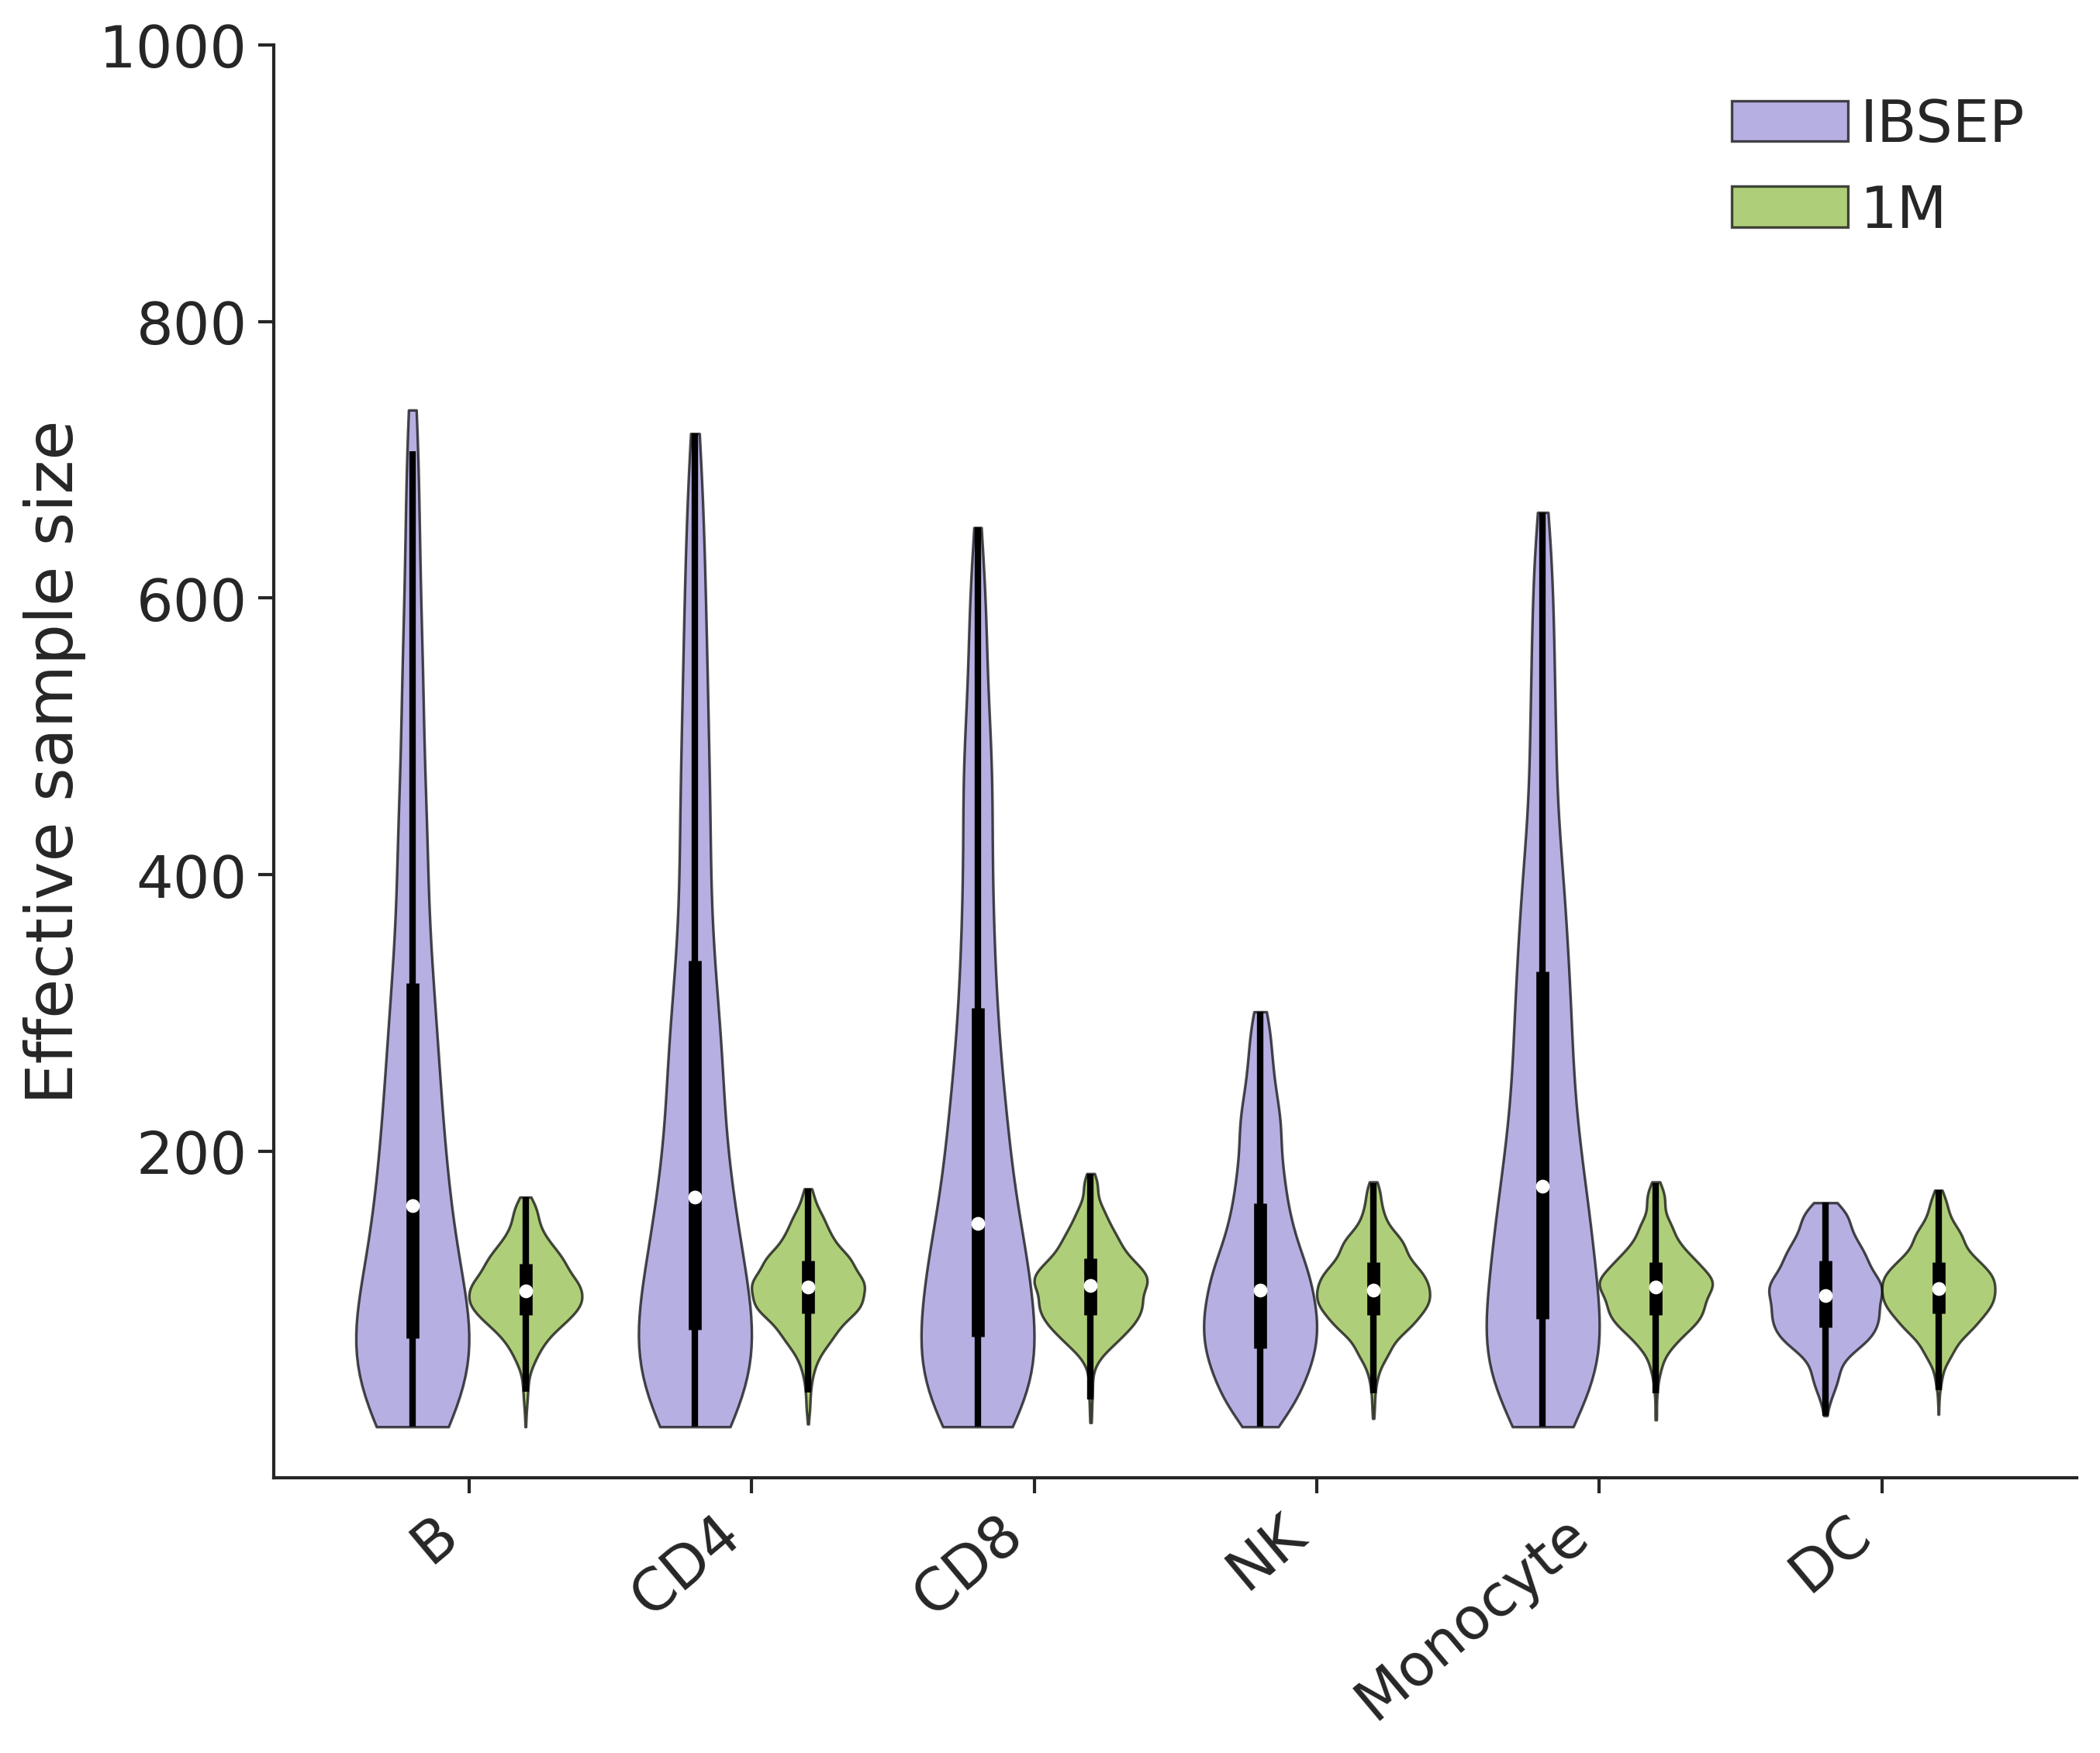

In [71]:
## violin plot
style.use('seaborn-white')
sorted_cell_types = ['B', 'CD4T', 'CD8T', 'NK', 'monocyte', 'DC']
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(10, 8), dpi=300)
width = 0.4

for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff_new'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 80))])
    vio1 = ax.violinplot(v_plot, positions=[i-0.5*width], widths=width, showextrema=False, showmedians=False,showmeans=False)
    for pc in vio1['bodies']:
        pc.set_facecolor('C2')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i-0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i-0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i-0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 95))])
    vio2 = ax.violinplot(v_plot, positions=[i+0.5*width], widths=width, showextrema=False, showmedians=False, showmeans=False)
    for pc in vio2['bodies']:
        pc.set_facecolor('C5')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i+0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i+0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i+0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

ax.legend(handles=[vio1["bodies"][0], vio2["bodies"][0]], 
                 labels=["IBSEP", "1M"],
                bbox_to_anchor=(1.0, 1.0),fontsize=18,handletextpad=0.2)
# ax.legend(handles=[vio1["bodies"][0], vio2["bodies"][0]], 
#                  labels=["Single cell", "IBSEP"+r" (Test $h_{ij}=0, p_{thres}=10^{-4})$"],
#                 bbox_to_anchor=(1.0, 1.0),fontsize='small',handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Effective sample size', fontsize=20)
ax.set_yticks([200, 400, 600, 800, 1000])
ax.set_xticks(range(len(sorted_cell_types)))
ax.set_xticklabels(['B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC'], rotation=40, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.grid(None)
plt.show()

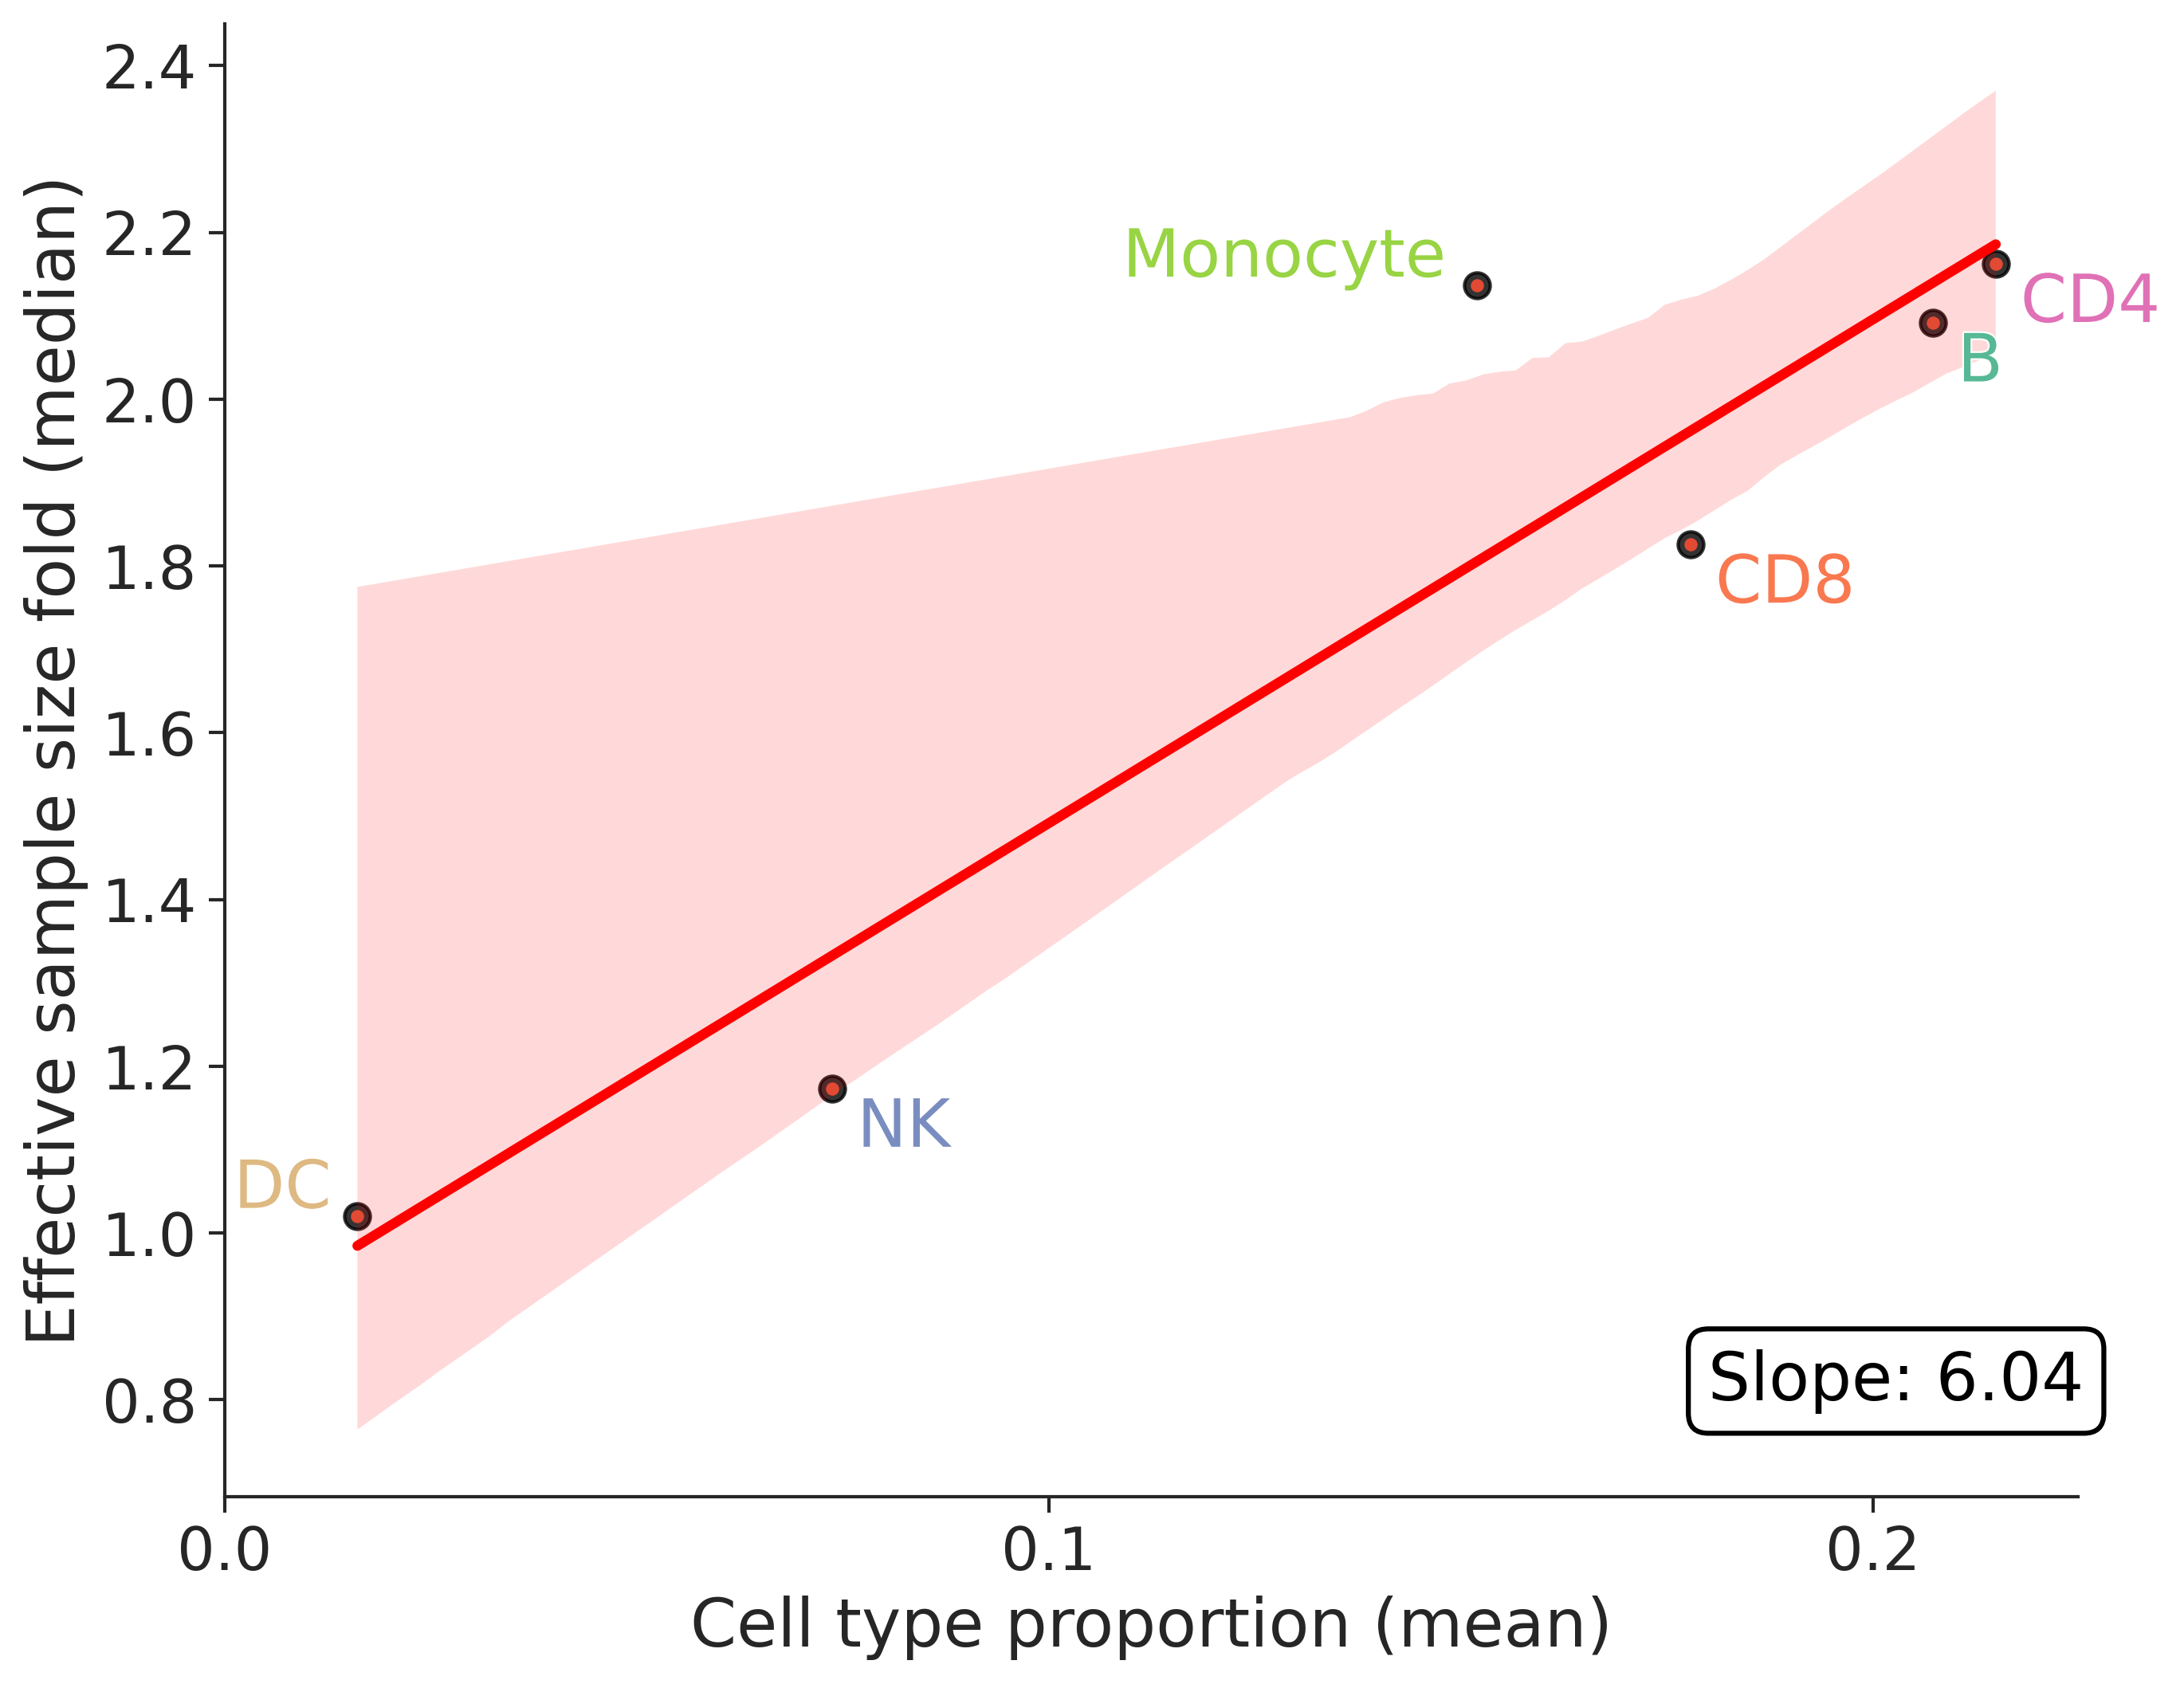

In [90]:
X2, Y2 = [], []
for c in sorted_cell_types:
    prop = prop_df.loc[prop_df.cell_type == c.replace('_', ' ')]['prop'].values[0]
    a = np.array(sample_sizes['Neff_f'][c])
    idx = np.where((a < np.percentile(a, 95)) & (a > 0))[0]
    X2.append(np.median(a[idx]))
    Y2.append(prop)
    
style.use('seaborn-white')
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
preg = sns.regplot(
    x=Y2, y=X2, ci=90, seed=0, n_boot=10000,
    line_kws=dict(color="r", linewidth=3), scatter_kws=dict(color='black', s=60)
)
slope, intercept, r_value, p_value, std_err = ss.linregress(x=preg.get_lines()[0].get_xdata(),y=preg.get_lines()[0].get_ydata())
texts = []
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
for i, (y2, x2) in enumerate(zip(Y2, X2)):
    if i == 0:
        y2 = y2 + 0.003
        x2 = x2 - 0.07
    if i == 1:
        y2 = y2 + 0.003
        x2 = x2 - 0.07
    if i == 2:
        y2 = y2 + 0.003
        x2 = x2 - 0.07
    if i == 3:
        y2 = y2 + 0.003
        x2 = x2 - 0.07
    if i == 4:
        y2 = y2 - 0.043
        x2 = x2 + 0.01
    if i == 5:
        y2 = y2 - 0.015
        x2 = x2 + 0.01
    texts.append(plt.text(x=y2, y=x2, s=['B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC'][i], 
                          bbox={'facecolor':'none', 'edgecolor':'none', 'pad':10},
                          path_effects=[pe.withStroke(linewidth=1, foreground='w')],
                          fontsize=20, color=colors[i]))
plt.text(x=0.18, y=0.8, s=f'Slope: {slope:.2f}', fontsize=20, color='black', 
         bbox=dict(boxstyle="round", lw=1.5,
                   ec=(0, 0, 0), fc=(1., 1, 1),
                   ))
ax.scatter(Y2, X2, marker='.', s=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 0.1, 0.2])
ax.set_xlabel('Cell type proportion (mean)', fontsize=20)
ax.set_ylabel('Effective sample size fold (median)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

## Heritability

In [ ]:
hsqs = {k: [] for k in sorted_cell_types}
for chr in tqdm(range(1, 23)):
    files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chr}/*_Omega_Sigma.npz')
    print(chr, len(files))
    for file in files:
        est = np.load(file)
        for i, c in enumerate(est['cell_types']):
            if 'shrinkOmega' in est.files:
                hsqs[c].append(est['shrinkOmega'][i, i])
            else:
                hsqs[c].append(est['oriOmega'][i, i])

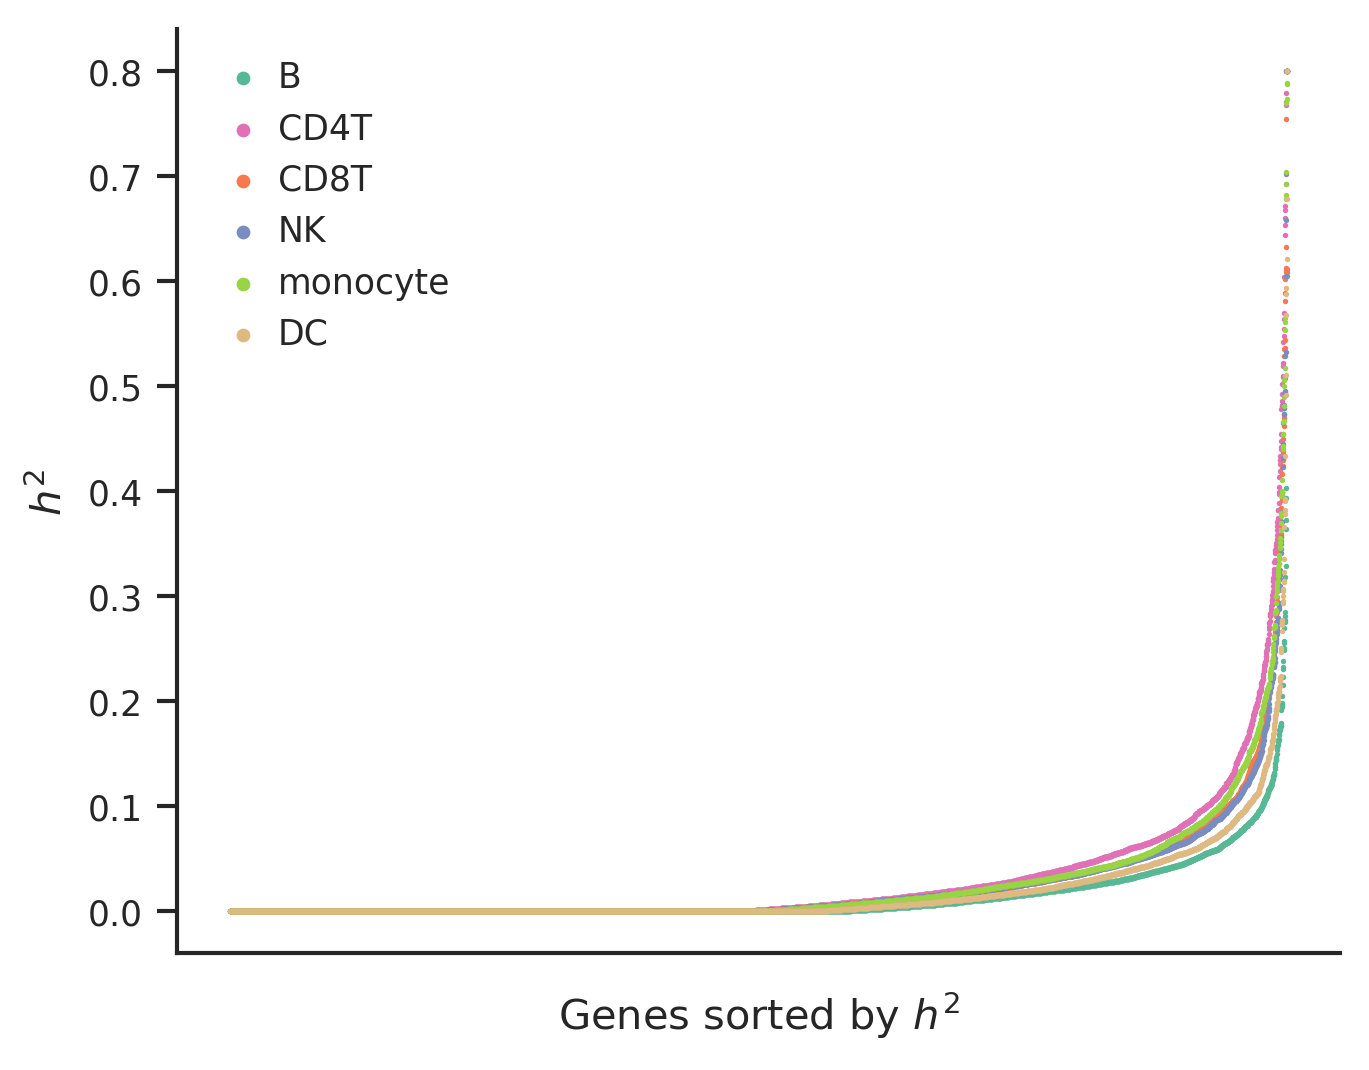

In [26]:
xmax = 10000
sns.set_context('paper',font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
for i, ct in enumerate(hsqs.keys()):
    x = np.array(hsqs[ct])
    x = np.sort(x[np.where((x > 0) & (x < 1))])
    ax.scatter(np.linspace(0, xmax, len(x)), x, c=colors[i], marker='.', s=1, label=ct.replace('_', ' '))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Genes sorted by '+r'$h^2$', fontsize='small')
ax.set_ylabel(r'$h^2$', fontsize='small')
ax.legend(loc='upper left', markerscale=5, fontsize='x-small', handletextpad=0)
ax.tick_params(axis='both', which='major', labelsize='x-small')

## Cell type correlation

In [ ]:
pval_thres = 1e-10
corrs = {}
for c1 in sorted_cell_types:
    for c2 in sorted_cell_types:
        idx1 = sorted_cell_types.index(c1)
        idx2 = sorted_cell_types.index(c2)
        if idx1 < idx2:
            corrs[f'{c1}-{c2}'] = []
for chr in tqdm(range(1, 23)):
    files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chr}/*_Omega_Sigma.npz')
    print(chr, len(files))
    for file in files:
        est = np.load(file)
        cells = est['cell_types']
        nc = len(cells)
        if nc > 1:
            for i in range(nc):
                c1 = cells[i]
                for j in range(nc):
                    c2 = cells[j]
                    idx1 = sorted_cell_types.index(c1)
                    idx2 = sorted_cell_types.index(c2)
                    if idx1 < idx2:
                        hij_z = est['oriOmega'][i, j] / est['oriOmega_se'][i, j]
                        hij_p = ss.norm.sf(abs(hij_z)) * 2
                        if hij_p < pval_thres:
                            # corr = est['Omega'][i, j] / np.sqrt(np.min([est['Omega'][i, i], 0.95]) * np.min([est['Omega'][j, j], 0.95]))
                            corrs[f'{c1}-{c2}'].append(1)
                        else:
                            corrs[f'{c1}-{c2}'].append(0)

In [31]:
corr_ratio = {}
for k, v in corrs.items():
    if len(v) == 0:
        corr_ratio[k] = 0
    else:
        corr_ratio[k] = sum(v) / len(v)

corr_mat = np.empty((6, 6))
corr_mat.fill(np.nan)
for k, v in corr_ratio.items():
    c1, c2 = k.split('-')
    i = sorted_cell_types.index(c1)
    j = sorted_cell_types.index(c2)
    corr_mat[i, j] = v
masked_array = np.ma.array (corr_mat, mask=np.isnan(corr_mat))

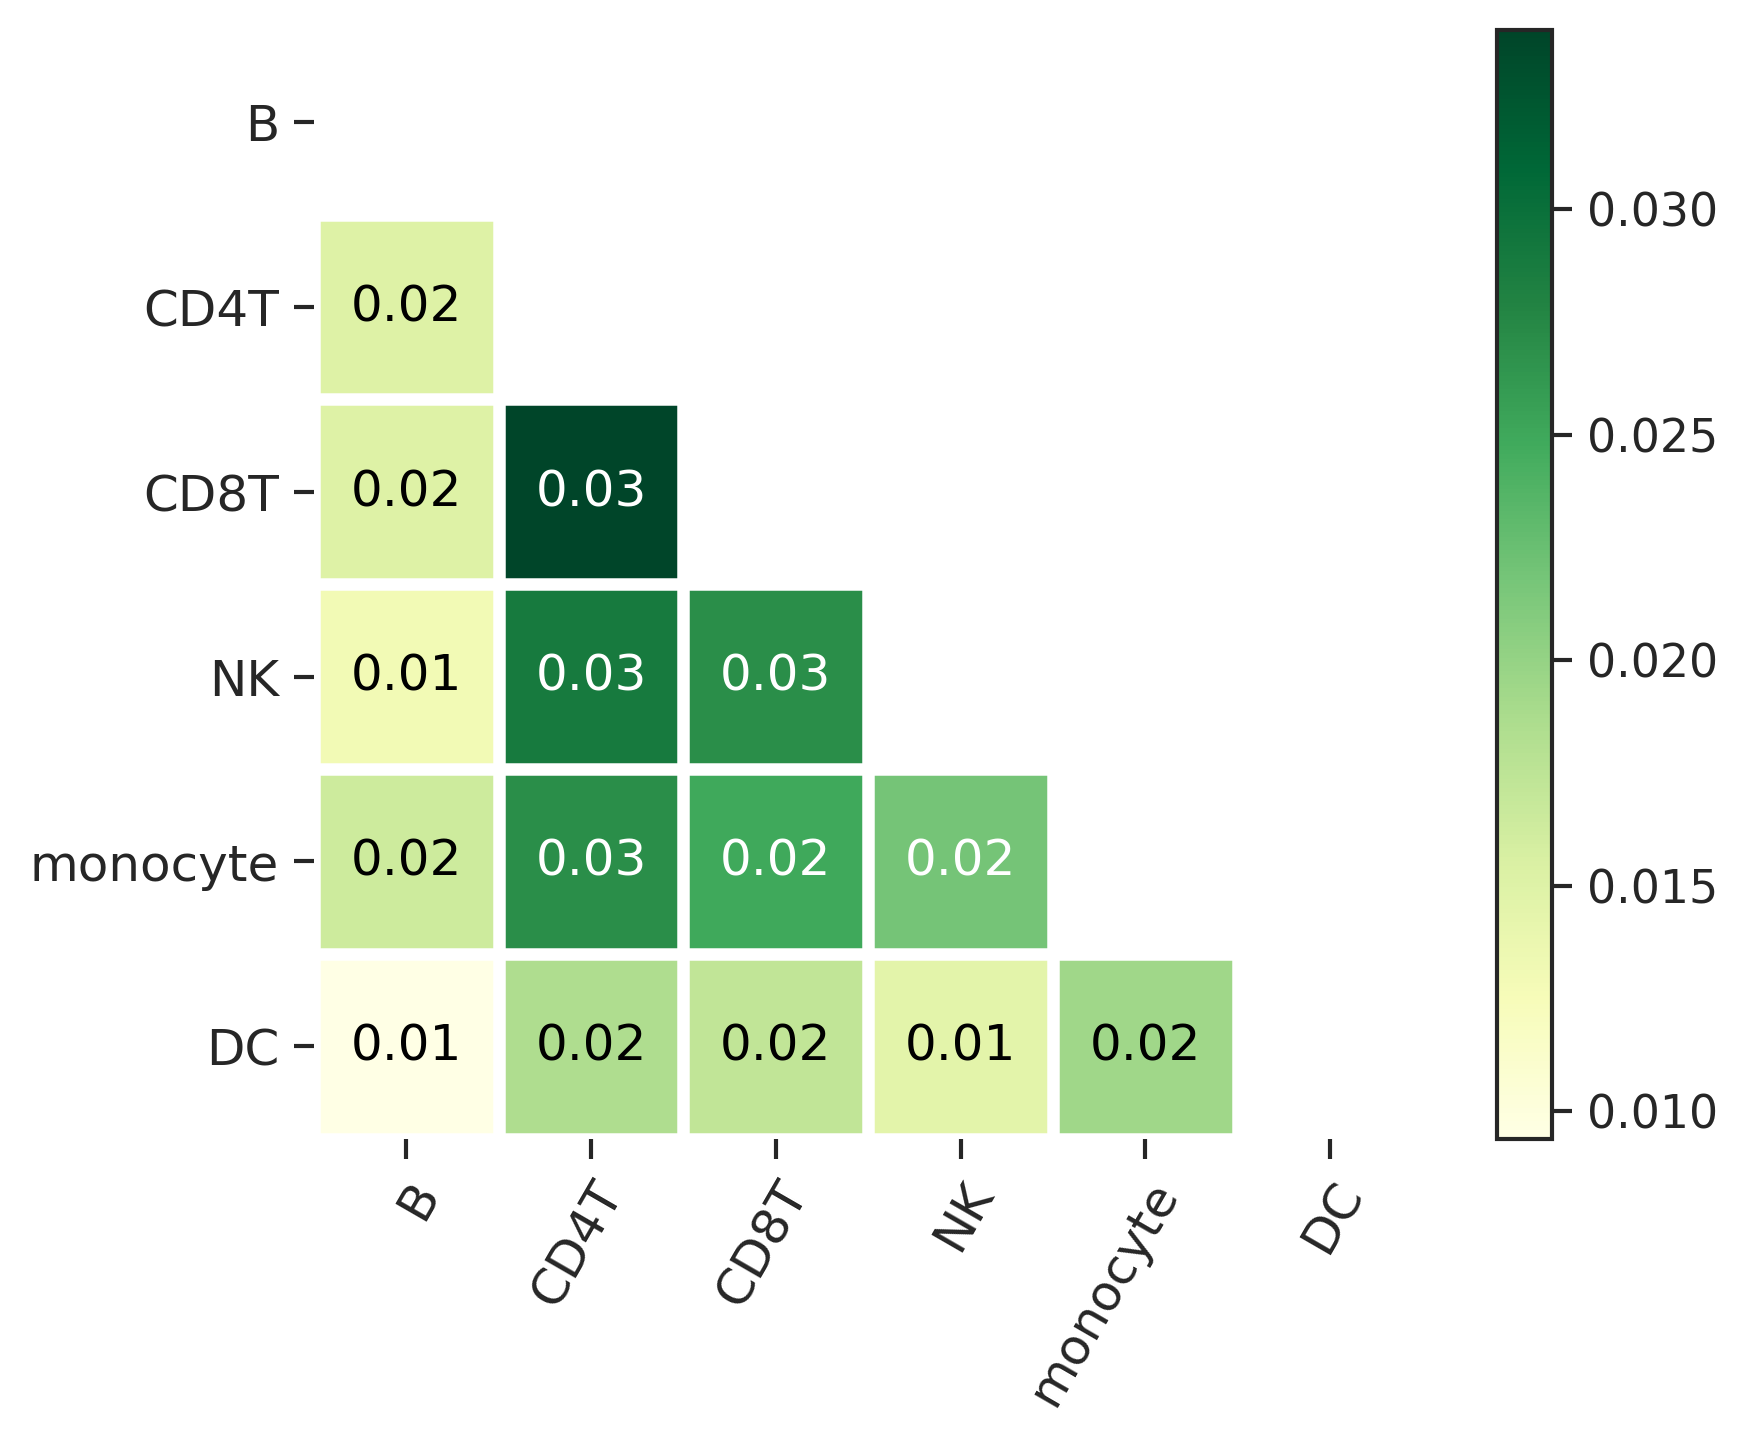

In [33]:
data = masked_array.T
cbarlabel = ''
col_labels = sorted_cell_types
row_labels = sorted_cell_types
threshold = None
valfmt="{x:.3f}"
textcolors=("black", "white")

fig, ax = plt.subplots(dpi=300)
# Plot the heatmap
cmap = mpl.cm.YlGn
cmap.set_bad('white',1.)
im = ax.imshow(data, cmap=cmap)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries.
ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=12)
ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=12)

# Let the horizontal axes labeling appear on bottom.
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)

ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

if not isinstance(data, (list, np.ndarray)):
    data = im.get_array()

# Normalize the threshold to the images color range.
if threshold is not None:
    threshold = im.norm(threshold)
else:
    threshold = im.norm(data.max())/2.

# Set default alignment to center, but allow it to be
# overwritten by textkw.
kw = dict(horizontalalignment="center",
          verticalalignment="center")
# kw.update(textkw)

# Get the formatter in case a string is supplied
if isinstance(valfmt, str):
    valfmt = mpl.ticker.StrMethodFormatter(valfmt)

# Loop over the data and create a `Text` for each "pixel".
# Change the text's color depending on the data.
texts = []
for i in range(1, data.shape[0]):
    for j in range(i):
        kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
        texts.append(text)
